# Design Calculations of Microject Engine


## Calculations 

### Microjet engine Thermal cycle

In [27]:
import math

def turbojet_engine_full(
    T1=288.15, P1=101325.0/1000.0, M0=0, pi_c=2.5, T4=1100,
    gamma=1.4, R=287, h_PR=43.2e6,
    eta_c=0.85, eta_t=0.9, pi_b=0.97, eta_b=0.97
):
    Cp = gamma * R / (gamma - 1)

    # -------- Intake (1-2) -------- #
    T2 = T1 #* (1 + (gamma - 1) / 2 * M0 ** 2)
    P2 = P1 #* (T2 / T1) ** (gamma / (gamma - 1))

    # -------- Compressor (2-3) -------- #
    P3 = pi_c * P2
    T3 = T2 * pi_c ** ((gamma - 1) / (gamma * eta_c))
    wc = Cp * (T3 - T2) / 1000  # kJ/kg

    # -------- Combustion Chamber (3-4) -------- #
    P4 = P3 * pi_b
    q_in = Cp * (T4 - T3) * eta_b  # J/kg
    f = (T4 - T3) / ((h_PR / Cp) - T4)

    # -------- Turbine (4-5) -------- #
    wt = wc  # per kg of air
    T5 = T4 - ((wt * 1000) / Cp)
    P5 = max(1e-6, P4 * (T5 / T4) ** (gamma / ((gamma - 1) * eta_t)))  # prevent divide-by-zero

    # -------- Nozzle (5-9) -------- #
    P9 = P1
    T9 = T5 * max(1e-6, (P9 / P5)) ** ((gamma - 1) / gamma)
    
    # Ensure physical realism (avoid math domain error)
    if T9 > T5:
        T9 = T5  # clamp
        
    delta_T = max( 1e-1, T5 - T9)
    
    Ve = math.sqrt(2 * Cp * (delta_T))
    Vi = M0 * math.sqrt(gamma * R * T1)

    # -------- Performance -------- #
    specific_thrust = Ve - Vi
    SFC = f / specific_thrust if specific_thrust > 0 else float('inf')
    eta_th = (Ve ** 2  / 2) / q_in
    eta_th_brayton = 1 - (1 / (pi_c ** ((gamma - 1) / gamma)))

    # -------- Results -------- #
    results = {
        "T1": T1, "P1": P1,
        "T2": T2, "P2": P2,
        "T3": T3, "P3": P3,
        "Compressor Work (kJ/kg)": wc,
        "Q in (J/kg)": q_in,
        "T4": T4, "P4": P4,
        "Cp": Cp,
        "Fuel-Air Ratio": f,
        "T5": T5, "P5": P5,
        "Exit Temperature (T9, K)": T9,
        "Exit Velocity (m/s)": Ve,
        "Specific Thrust (m/s)": specific_thrust,
        "Specific Fuel Consumption (kg/N·s)": SFC,
        "Thermal Efficiency (%)": eta_th * 100,
        "Brayton Efficiency (%)": eta_th_brayton * 100,
        "Cp": Cp,
    }
    return results


# Q#1
if __name__ == "__main__":
    output = turbojet_engine_full()
    for key, val in output.items():
        print(f"{key:40s}: {val:.6f}")


T1                                      : 288.150000
P1                                      : 101.325000
T2                                      : 288.150000
P2                                      : 101.325000
T3                                      : 392.084768
P3                                      : 253.312500
Compressor Work (kJ/kg)                 : 104.402475
Q in (J/kg)                             : 689767.824556
T4                                      : 1100.000000
P4                                      : 245.713125
Cp                                      : 1004.500000
Fuel-Air Ratio                          : 0.016893
T5                                      : 996.065232
P5                                      : 167.031420
Exit Temperature (T9, K)                : 863.504247
Exit Velocity (m/s)                     : 516.057184
Specific Thrust (m/s)                   : 516.057184
Specific Fuel Consumption (kg/N·s)      : 0.000033
Thermal Efficiency (%)                  : 19.

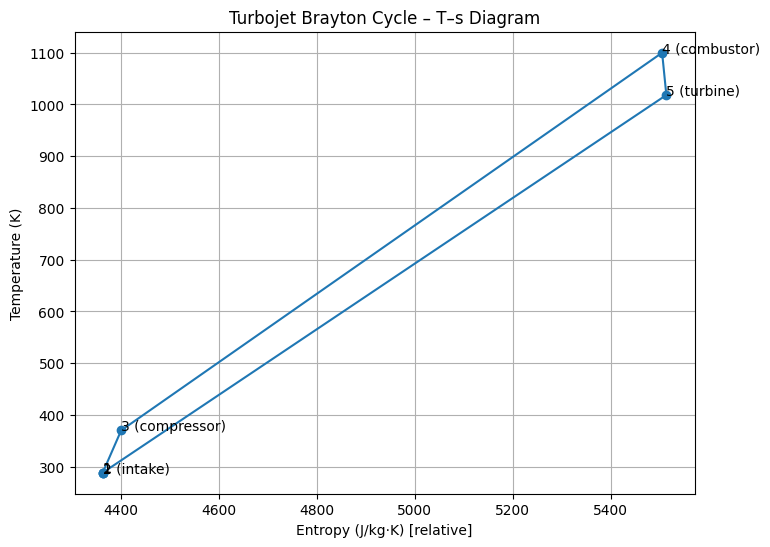

In [12]:
# --------------------------------------------------
# Draw T–s diagram for the turbojet cycle
# --------------------------------------------------
import matplotlib.pyplot as plt

def draw_ts_diagram():
    res = turbojet_engine_full()
    Cp = res["Cp"]
    gamma = 1.4
    R = 287

    # Ideal-gas constant Cp, Cv, etc.
    Cv = Cp - R

    # ---- State points ----
    T1, P1 = res["T1"], res["P1"]
    T2, P2 = res["T2"], res["P2"]
    T3, P3 = res["T3"], res["P3"]
    T4, P4 = res["T4"], res["P4"]
    T5, P5 = res["T5"], res["P5"]

    # ---- Compute ideal entropy (relative) ----
    def entropy(T, P):
        return Cp * math.log(T) - R * math.log(P)

    s1 = entropy(T1, P1)
    s2 = entropy(T2, P2)
    s3 = entropy(T3, P3)
    s4 = entropy(T4, P4)
    s5 = entropy(T5, P5)

    # Ordered for plotting cycle:
    T_vals = [T1, T2, T3, T4, T5, T1]
    s_vals = [s1, s2, s3, s4, s5, s1]

    plt.figure(figsize=(8, 6))
    plt.plot(s_vals, T_vals, marker="o")
    plt.xlabel("Entropy (J/kg·K) [relative]")
    plt.ylabel("Temperature (K)")
    plt.title("Turbojet Brayton Cycle – T–s Diagram")
    plt.grid(True)

    # Label points
    labels = ["1", "2 (intake)", "3 (compressor)", "4 (combustor)", "5 (turbine)", "1"]
    for i, txt in enumerate(labels):
        plt.annotate(txt, (s_vals[i], T_vals[i]))

    plt.show()


# Run plot
if __name__ == "__main__":
    draw_ts_diagram()

### Compressor Centrifugal Compressor Design 1

In [30]:
import numpy as np

# --- 1. Constants and Initial Assumptions (Chosen to fit constraints) ---
# Gas Properties (Air)
GAMMA = 1.4      # Specific heat ratio
R_GAS = 287.0    # Specific gas constant (J/kg/K)
CP = GAMMA * R_GAS / (GAMMA - 1) # Specific heat at constant pressure (approx 1005 J/kg/K)

# Standard Inlet Conditions (Total)
T01 = 288.15     # K (Standard Sea Level)
P01 = 101325.0   # Pa (Standard Sea Level)

# Design Requirements
PI = 2.102704          # Pressure ratio
M_DOT = 0.171581      # kg/s (Mass flow rate)
D2_MAX = 0.07    # m (Maximum impeller diameter)
M_MAX = 0.9       # Maximum Mach number

# Chosen Design Parameters (within recommended ranges)
ETA_C = 0.85     # Compressor Isentropic Efficiency
PSI = 0.6       # Loading coefficient: {0.5 < psi < 0.6}
BETA_2 = 47.905364    # Backward swept angle (degrees): {0 < beta_2 <= 60}
ZETA = 0.387923       # Hub to tip diameter ratio (r_h1/r_t1): {0.2 < zeta < 0.7}
DELTA = 0.602445      # Rotor tip diameter ratio (r_t1/r_2): {0.5 < delta < 0.75}

# Set d2 to maximum constraint
R2 = D2_MAX / 2.0 # Impeller tip radius (m)

# --- 2. Isentropic and Total Enthalpy Rise ---
T02_T01_IDEAL = PI**((GAMMA - 1) / GAMMA)
T02_T01 = 1 + (1 / ETA_C) * (T02_T01_IDEAL - 1)
T02 = T01 * T02_T01

DELTA_H_TOT = CP * (T02 - T01)

# --- 3. Impeller Tip Speed and Rotational Speed ---
U2 = np.sqrt(DELTA_H_TOT / PSI)

N_RPS = U2 / (2 * np.pi * R2)
N_RPM = N_RPS * 60.0

# --- 4. Impeller Outlet Velocity Components ---
# Assuming c_u1 is zero (Axial Inlet)
CU2 = DELTA_H_TOT / U2

# Radial velocity component using the backward swept angle
CR2 = (U2 - CU2) / np.tan(np.deg2rad(BETA_2))
C2 = np.sqrt(CU2**2 + CR2**2)

# --- 5. Inducer Inlet Diameters and Area (Max Area to meet mass flow) ---
RT1 = DELTA * R2
RH1 = ZETA * RT1

A1 = np.pi * (RT1**2 - RH1**2)

# Inlet density (approximated as static inlet density)
RHO1 = P01 / (R_GAS * T01)

# --- 6. Inducer Inlet Meridional Velocity and Flow Coefficient (Phi) ---
CM1 = M_DOT / (RHO1 * A1)

PHI = CM1 / U2

# --- 7. Mach Number Check (Stator/Diffuser Inlet) ---
# Need to estimate Static Temperature T2. A common approximation for the impeller is T2 = T02 - 0.5 * c2**2 / Cp
# Alternatively, a more conservative estimate is just below T02. Let's assume a reasonable T2.
T2_EST = T02 - 0.5 * C2**2 / CP # Energy equation: T02 = T2 + c2^2 / (2*Cp)

if T2_EST < T01: # Check if static temperature is physically possible
    T2_EST = T02 - 0.1 * (T02 - T01) # Use a simple drop

A2_EST = np.sqrt(GAMMA * R_GAS * T2_EST) # Speed of sound
M2_STATOR = C2 / A2_EST

# --- 8. Print Results ---
print("## Centrifugal Compressor Design Results\n")
print(f"**Design Requirements:**")
print(f"  - Pressure Ratio (π): {PI}")
print(f"  - Mass Flow Rate (ṁ): {M_DOT} kg/s")
print(f"  - Max Impeller Diameter (d₂): {D2_MAX*100:.2f} cm\n")

print(f"**Thermodynamic/Speed Calculations:**")
print(f"  - Total Temp Ratio (T₀₂/T₀₁): {T02_T01:.4f}")
print(f"  - Total Enthalpy Rise (Δh_tot): {DELTA_H_TOT/1000:.1f} kJ/kg")
print(f"  - Impeller Tip Speed (U₂): {U2:.1f} m/s")
print(f"  - Rotational Speed (N): {N_RPM:.0f} RPM")
print(f"  - Loading Coefficient (ψ): {PSI:.3f} (Chosen)\n")

print(f"**Impeller Geometry (Output/Exit):**")
print(f"  - Impeller Diameter (d₂): {D2_MAX*100:.2f} cm")
print(f"  - Tangential Velocity (cᵤ₂): {CU2:.1f} m/s")
print(f"  - Radial Velocity (cᵣ₂): {CR2:.1f} m/s")
print(f"  - Absolute Outlet Velocity (c₂): {C2:.1f} m/s")
print(f"  - Backward Swept Angle (|β₂|): {BETA_2:.0f}° (Max allowed)\n")

print(f"**Inducer Geometry (Inlet):**")
print(f"  - Inducer Tip Diameter (dₜ₁): {RT1*2*100:.2f} cm")
print(f"  - Inducer Hub Diameter (dₕ₁): {RH1*2*100:.2f} cm")
print(f"  - Hub/Tip Ratio (ζ): {ZETA:.2f} (Chosen min)")
print(f"  - Tip/Impeller Ratio (δ): {DELTA:.2f} (Chosen max)\n")

print(f"**Inlet Flow & Design Check:**")
print(f"  - Required Meridional Velocity (cₘ₁): {CM1:.1f} m/s")
print(f"  - Flow Coefficient (φ): {PHI:.3f} (Within range 0.2-0.4)")
print(f"  - Estimated Static Temp (T₂): {T2_EST:.1f} K")
print(f"  - Stator Inlet Mach No. (M₂): {M2_STATOR:.2f}")

if M2_STATOR <= M_MAX:
    print(f"  - **Mach No. Check:** PASS (M₂ <= {M_MAX})")
else:
    print(f"  - **Mach No. Check:** FAIL (M₂ > {M_MAX})")

## Centrifugal Compressor Design Results

**Design Requirements:**
  - Pressure Ratio (π): 2.102704
  - Mass Flow Rate (ṁ): 0.171581 kg/s
  - Max Impeller Diameter (d₂): 7.00 cm

**Thermodynamic/Speed Calculations:**
  - Total Temp Ratio (T₀₂/T₀₁): 1.2783
  - Total Enthalpy Rise (Δh_tot): 80.6 kJ/kg
  - Impeller Tip Speed (U₂): 366.4 m/s
  - Rotational Speed (N): 99975 RPM
  - Loading Coefficient (ψ): 0.600 (Chosen)

**Impeller Geometry (Output/Exit):**
  - Impeller Diameter (d₂): 7.00 cm
  - Tangential Velocity (cᵤ₂): 219.9 m/s
  - Radial Velocity (cᵣ₂): 132.4 m/s
  - Absolute Outlet Velocity (c₂): 256.7 m/s
  - Backward Swept Angle (|β₂|): 48° (Max allowed)

**Inducer Geometry (Inlet):**
  - Inducer Tip Diameter (dₜ₁): 4.22 cm
  - Inducer Hub Diameter (dₕ₁): 1.64 cm
  - Hub/Tip Ratio (ζ): 0.39 (Chosen min)
  - Tip/Impeller Ratio (δ): 0.60 (Chosen max)

**Inlet Flow & Design Check:**
  - Required Meridional Velocity (cₘ₁): 118.0 m/s
  - Flow Coefficient (φ): 0.322 (Within range 0.2-0

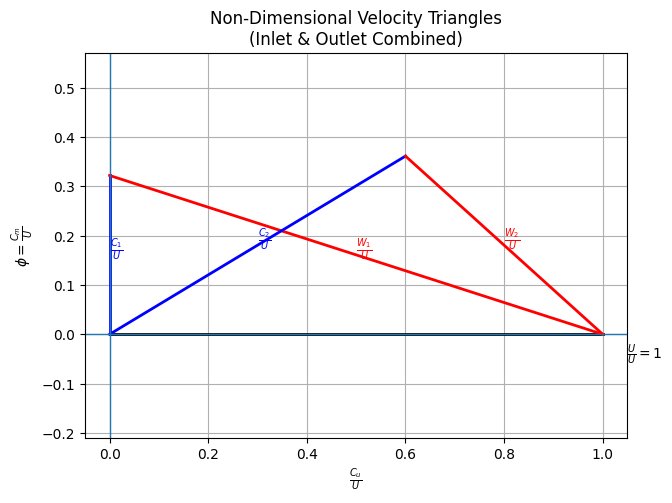

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# ==============================
# NON-DIMENSIONAL VELOCITIES
# ==============================

# Inlet
Cu1_bar = 0.0
Cm1_bar = CM1 / U2

# Outlet
Cu2_bar = CU2 / U2
Cm2_bar = CR2 / U2

# Relative velocities
Wu1_bar = Cu1_bar - 1.0
Wu2_bar = Cu2_bar - 1.0

# ==============================
# PLOT
# ==============================
plt.figure(figsize=(7,5))

# ---- Inlet Triangle ----
plt.plot([0, Cu1_bar], [0, Cm1_bar], 'b', linewidth=2)     # C1
plt.plot([0, 1], [0, 0], 'k', linewidth=2)                 # U
plt.plot([1, Cu1_bar], [0, Cm1_bar], 'r', linewidth=2)     # W1

# ---- Outlet Triangle ----
plt.plot([0, Cu2_bar], [0, Cm2_bar], 'b', linewidth=2)     # C2
plt.plot([1, Cu2_bar], [0, Cm2_bar], 'r', linewidth=2)     # W2

# ---- Labels ----
plt.text(Cu1_bar/2, Cm1_bar/2, r"$\frac{C_1}{U}$", color='b')
plt.text(Cu2_bar/2, Cm2_bar/2, r"$\frac{C_2}{U}$", color='b')
plt.text(1.05, -0.05, r"$\frac{U}{U}=1$", color='k')
plt.text((1+Cu1_bar)/2, Cm1_bar/2, r"$\frac{W_1}{U}$", color='r')
plt.text((1+Cu2_bar)/2, Cm2_bar/2, r"$\frac{W_2}{U}$", color='r')

# ---- Axes & Annotations ----
plt.axhline(0, linewidth=1)
plt.axvline(0, linewidth=1)

plt.xlabel(r"$\frac{C_u}{U}$")
plt.ylabel(r"$\phi = \frac{C_m}{U}$")

plt.title("Non-Dimensional Velocity Triangles\n(Inlet & Outlet Combined)")
plt.grid(True)
plt.axis('equal')

plt.show()


### Combustion Chamber 2

In [ ]:
import math

# ==============================================================================
# CONFIGURATION & INPUTS
# ==============================================================================
class Config:
    # Constants
    R_AIR = 287.05          # J/kg·K
    LHV_KEROSENE = 43.2e6   # J/kg
    CP_MIX = 1200.0         # J/kg·K (approx for combustion products)
    
    # Fuel Properties
    AFR_STOICH = 14.7
    F_ST = 1.0 / AFR_STOICH

    # Design Operating Conditions
    M_DOT_AIR = 0.148847        # kg/s
    P3 = 2.5*101325           # Pa (2*101325 kPa)
    T3 = 389.6              # K
    T4_TARGET = 1100.0      # K
    
    # Constraints & Limits
    T_MAX_AD_LIMIT = 2200.0 # K (Adiabatic limit)
    T_WALL_MAX = 1200.0     # K
    ETA_COMB = 0.97         # Combustion Efficiency
    THETA_MAX = 7.3e7       # Loading parameter limit
    MAX_RES_TIME = 0.010    # seconds (10ms)
    PATTERN_FACTOR_LIMIT = 0.25
    LINER_DP_FRAC = 0.06    # 6% Pressure drop

# ==============================================================================
# CALCULATION MODULES
# ==============================================================================

def calc_fuel_flow(cfg: Config):
    """Calculates fuel flow, checking adiabatic limits."""
    # 1. Adiabatic Limit Check
    # Estimate max possible T4 (Complete combustion, no losses)
    # Using simple Cp average for flame temp est
    cp_avg_est = 1102.5
    t4_max_possible = cfg.T3 + (cfg.ETA_COMB * cfg.F_ST * cfg.LHV_KEROSENE) / (cp_avg_est * (1 + cfg.F_ST))
    
    # Safety clamp: Limit T4 to 95% of theoretical max
    t4_design = min(cfg.T4_TARGET, 0.95 * t4_max_possible)

    # 2. Required Fuel Flow
    # Energy Balance: m_f * LHV * eta = (m_a + m_f) * cp_mix * (T4 - T3)
    # Simplified: m_f = (m_a * cp * dT) / (eta * LHV)
    m_dot_f = (cfg.M_DOT_AIR * cfg.CP_MIX * (t4_design - cfg.T3)) / (cfg.ETA_COMB * cfg.LHV_KEROSENE)
    
    f_actual = m_dot_f / cfg.M_DOT_AIR
    phi = f_actual / cfg.F_ST

    return {
        "m_dot_f": m_dot_f,
        "f_actual": f_actual,
        "phi": phi,
        "T4_actual": t4_design,
        "T4_max_ad": t4_max_possible
    }

def calc_reference_geometry(cfg: Config):
    """Iteratively solves for Reference Area based on Loading Parameter."""
    # Minimum Area based on reduced Mach/Flow Parameter
    mfp_design = 0.003 # Suggested values in page 59 in the lecture pdf
    a_ref = (cfg.M_DOT_AIR * math.sqrt(cfg.T3)) / (cfg.P3 * mfp_design) * 1.2 # Start 20% larger
    
    theta = 0.0
    d_ref = 0.0
    
    # Pre-calculate constant term for Theta: P^1.75 * exp(T/300) / m_dot
    theta_const = (cfg.P3**1.75 * math.exp(cfg.T3/300.0)) / cfg.M_DOT_AIR

    for _ in range(20):
        d_ref = math.sqrt(4.0 * a_ref / math.pi)
        
        # Theta = P^1.75 * A_ref * D_ref^0.75 * exp(T/300) / m_dot
        theta = theta_const * a_ref * (d_ref**0.75)

        if theta > cfg.THETA_MAX:
            a_ref *= 1.05 # Increase area to reduce theta (counter-intuitive but based on reaction rate volume)
        elif theta < 0.9 * cfg.THETA_MAX:
            a_ref *= 0.98
        else:
            break
            
    return {"A_ref": a_ref, "D_ref": d_ref, "theta": theta}

def calc_combustor_geometry(cfg: Config, a_ref, t4_actual):
    """Designs liner and length based on Residence Time."""
    # Liner Initial Sizing
    a_liner = 0.70 * a_ref
    d_liner = math.sqrt(4.0 * a_liner / math.pi)
    
    # Density for residence time (using average T)
    t_avg = (cfg.T3 + t4_actual) / 2
    rho_avg = cfg.P3 / (cfg.R_AIR * t_avg)
    
    # Target L/D
    l_over_d = 1.991060
    l_total = 0.0
    tau_res = 0.0
    vol_comb = 0.0

    # Iteratively adjust Length to meet Residence Time
    for _ in range(15):
        l_total = l_over_d * d_liner
        vol_comb = a_liner * l_total
        tau_res = (rho_avg * vol_comb) / cfg.M_DOT_AIR

        if tau_res > cfg.MAX_RES_TIME:
            l_over_d *= 0.95 # Shorten
        elif tau_res < cfg.MAX_RES_TIME * 0.8:
            l_over_d *= 1.03 # Lengthen
        else:
            break
            
    return {
        "A_liner": a_liner, "D_liner": d_liner,
        "L_total": l_total, "L_over_D": l_over_d,
        "Vol_comb": vol_comb, "tau_res": tau_res,
        "rho_avg": rho_avg
    }

def calc_air_distribution(cfg: Config, fuel_res, geom_res):
    """Distributes air into Primary, Secondary, Dilution, and Cooling."""
    m_dot_f = fuel_res["m_dot_f"]
    
    # 1. Primary Zone (PZ)
    phi_pz = 1.2        # Suggested values in page 65 in the lecture pdf
    epsilon_pz = 0.75  # Fraction of fuel burned in PZ
    m_f_pz = epsilon_pz * m_dot_f
    m_a_pz = m_f_pz / (phi_pz * cfg.F_ST)
    
    # 2. Secondary Zone (SZ)
    phi_sz = 0.65       # Suggested values in page 65 in the lecture pdf
    m_f_sz = m_dot_f - m_f_pz
    m_a_sz = m_f_sz / (phi_sz * cfg.F_ST)
    
    # 3. Cooling Flow (Lefebvre approx)
    # Estimate gas temp in primary
    t_gas_pz = cfg.T3 + (phi_pz * epsilon_pz * (cfg.T_MAX_AD_LIMIT - cfg.T3))
    eta_film = 0.55
    # Clamp cooling factor between 20% and 30% usually
    mu_c_calc = (t_gas_pz - cfg.T_WALL_MAX) / (6.0 * eta_film * (cfg.T_WALL_MAX - cfg.T3))
    mu_c = max(0.20, min(0.30, mu_c_calc))
    m_a_cool = mu_c * cfg.M_DOT_AIR
    
    # 4. Dilution Zone (Remainder)
    m_a_dz = cfg.M_DOT_AIR - (m_a_pz + m_a_sz + m_a_cool)
    
    # Safety: If dilution is negative, squeeze other zones (unlikely with these inputs)
    if m_a_dz < 0:
        m_a_cool = max(0.15 * cfg.M_DOT_AIR, m_a_cool - 0.05 * cfg.M_DOT_AIR)
        m_a_dz = cfg.M_DOT_AIR - (m_a_pz + m_a_sz + m_a_cool)

    # Fractions
    mu = {
        "pz": m_a_pz / cfg.M_DOT_AIR,
        "sz": m_a_sz / cfg.M_DOT_AIR,
        "cool": m_a_cool / cfg.M_DOT_AIR,
        "dz": m_a_dz / cfg.M_DOT_AIR
    }
    
    # Zone Lengths
    L_total = geom_res["L_total"]
    lengths = {
        "pz": 0.35 * L_total,
        "sz": 0.25 * L_total,
        "dz": 0.40 * L_total
    }
    
    return {"m_dist": {"pz": m_a_pz, "sz": m_a_sz, "cool": m_a_cool, "dz": m_a_dz}, 
            "mu": mu, 
            "lengths": lengths}

def design_swirler(a_liner):
    """Designs the Swirler geometry."""
    swirl_target = 0.7
    hub_tip_ratio = 0.4
    
    # Vane angle calc
    lam = hub_tip_ratio
    num = (1 - lam**3)
    den = (1 - lam**2)
    tan_beta = (1.5 * swirl_target * den) / num
    beta_deg = math.degrees(math.atan(tan_beta))
    
    # Area sizing (12% of liner)
    a_swirler = 0.12 * a_liner
    d_swirler = math.sqrt(4 * a_swirler / math.pi)
    
    return {
        "swirl_num": swirl_target,
        "beta_deg": beta_deg,
        "D_swirler": d_swirler
    }

def design_holes(cfg: Config, mass_dist):
    """Calculates hole quantities and sizes."""
    
    def solve_hole(m_dot, cd, delta_p_frac, zone_type):
        if m_dot <= 1e-9: return {"N": 0, "d": 0, "rows": 0}
        
        # Target velocity (based on pressure drop)
        # dP = 0.5 * rho * V^2  -> V = sqrt(2*dP/rho)
        dp_pa = delta_p_frac * cfg.P3
        rho_hole = cfg.P3 / (cfg.R_AIR * cfg.T3) # Approx inlet density
        v_target = math.sqrt(2 * dp_pa / rho_hole)
        
        # Limit V to incompressible range
        c_sound = math.sqrt(1.4 * cfg.R_AIR * cfg.T3)
        if v_target > 0.3 * c_sound:
             v_target = 0.3 * c_sound
             
        a_req = m_dot / (rho_hole * v_target * cd)
        
        # Geometry selection
        if zone_type == "pz":    d_mm, rows = 16, 1
        elif zone_type == "sz":  d_mm, rows = 6.0, 2
        elif zone_type == "cool":d_mm, rows = 3.0, 3
        else:                    d_mm, rows = 10.0, 2 # dilution
        
        d_m = d_mm / 1000.0
        a_hole = math.pi * (d_m/2)**2
        n_holes = math.ceil(a_req / a_hole)
        
        # Adjust for symmetry
        n_holes = math.ceil(n_holes / rows) * rows
        
        # Recalculate exact diameter needed for integer number of holes
        d_actual = math.sqrt((4 * a_req) / (n_holes * math.pi))
        
        return {"N": n_holes, "d_mm": d_actual * 1000, "rows": rows}

    return {
        "pz": solve_hole(mass_dist["pz"], 0.75, 0.07, "pz"),
        "sz": solve_hole(mass_dist["sz"], 0.65, 0.05, "sz"),
        "cool": solve_hole(mass_dist["cool"], 0.85, 0.03, "cool"),
        "dz": solve_hole(mass_dist["dz"], 0.60, 0.04, "dz"),
    }

# ==============================================================================
# MAIN EXECUTION & PRINTING
# ==============================================================================

def print_centered(text, width=78, char=" "):
    print(f"║ {text.center(width)} ║")

def print_row(label, value, width=78):
    print(f"║ {label:<45} {value:<32} ║")

def print_separator(width=78):
    print("╠" + "═" * (width + 2) + "╣")

def run_design():
    cfg = Config()
    
    # --- Run Calculations ---
    fuel = calc_fuel_flow(cfg)
    ref_geom = calc_reference_geometry(cfg)
    comb_geom = calc_combustor_geometry(cfg, ref_geom["A_ref"], fuel["T4_actual"])
    air_dist = calc_air_distribution(cfg, fuel, comb_geom)
    swirler = design_swirler(comb_geom["A_liner"])
    holes = design_holes(cfg, air_dist["m_dist"])
    
    # --- Performance Estimates ---
    # Pattern Factor Correlation: PF = 0.1 * sqrt(mu_dz / mu_pz)
    pf = 0.1 * math.sqrt(air_dist["mu"]["dz"] / (air_dist["mu"]["pz"] + 1e-6))
    
    # Recirculation Zone (approx 0.8 * D_liner)
    l_recirc = 0.8 * comb_geom["D_liner"]

    # --- Print Report ---
    W = 78 # Inner width
    print("\n" + "╔" + "═" * (W + 2) + "╗")
    print_centered("GAS TURBINE COMBUSTOR: PRELIMINARY DESIGN REPORT", W)
    print("╠" + "═" * (W + 2) + "╣")
    
    # 1. Operating Conditions
    print_centered("1. OPERATING CONDITIONS", W)
    print_separator(W)
    print_row("Mass Flow Rate (Air)", f"{cfg.M_DOT_AIR:.3f} kg/s", W)
    print_row("Inlet Pressure (P3)", f"{cfg.P3/1000:.1f} kPa", W)
    print_row("Inlet Temperature (T3)", f"{cfg.T3:.1f} K", W)
    print_row("Target Outlet Temp (T4)", f"{fuel['T4_actual']:.1f} K", W)
    print_row("Delta T", f"{fuel['T4_actual'] - cfg.T3:.1f} K", W)
    print_separator(W)

    # 2. Fuel & Combustion
    print_centered("2. FUEL & COMBUSTION", W)
    print_separator(W)
    print_row("Fuel Flow Rate", f"{fuel['m_dot_f']:.5f} kg/s", W)
    print_row("Fuel-Air Ratio (f)", f"{fuel['f_actual']:.4f}", W)
    print_row("Equivalence Ratio (phi)", f"{fuel['phi']:.3f}", W)
    print_row("Combustion Efficiency", f"{cfg.ETA_COMB:.2f}", W)
    print_separator(W)

    # 3. Geometry
    print_centered("3. COMBUSTOR GEOMETRY", W)
    print_separator(W)
    print_row("Reference Diameter (Casing)", f"{ref_geom['D_ref']*1000:.1f} mm", W)
    print_row("Liner Diameter", f"{comb_geom['D_liner']*1000:.1f} mm", W)
    print_row("Liner Cross-Section Area", f"{comb_geom['A_liner']:.5f} m²", W)
    print_row("Total Combustor Length", f"{comb_geom['L_total']*1000:.1f} mm", W)
    print_row("Length-to-Diameter Ratio (L/D)", f"{comb_geom['L_over_D']:.2f}", W)
    print_row("Combustor Volume", f"{comb_geom['Vol_comb']*1000:.2f} Liters", W)
    print_separator(W)

    # 4. Zone Distribution
    print_centered("4. ZONAL DISTRIBUTION", W)
    print_separator(W)
    # Header for zones
    print(f"║ {'ZONE':<15} {'AIR %':<10} {'MASS (kg/s)':<15} {'LENGTH (mm)':<15} {'HOLES':<18} ║")
    print("╟" + "─"*78 + "╢")
    
    def print_zone_line(name, mu, m, l, h_data):
        h_str = f"{h_data['N']} x {h_data['d_mm']:.1f}mm"
        print(f"║ {name:<15} {mu*100:<10.1f} {m:<15.4f} {l*1000:<15.1f} {h_str:<18} ║")

    print_zone_line("Primary", air_dist["mu"]["pz"], air_dist["m_dist"]["pz"], air_dist["lengths"]["pz"], holes["pz"])
    print_zone_line("Secondary", air_dist["mu"]["sz"], air_dist["m_dist"]["sz"], air_dist["lengths"]["sz"], holes["sz"])
    print_zone_line("Cooling", air_dist["mu"]["cool"], air_dist["m_dist"]["cool"], 0, holes["cool"])
    print_zone_line("Dilution", air_dist["mu"]["dz"], air_dist["m_dist"]["dz"], air_dist["lengths"]["dz"], holes["dz"])
    print_separator(W)

    # 5. Swirler & Recirculation
    print_centered("5. AERODYNAMICS & SWIRL", W)
    print_separator(W)
    print_row("Swirl Number", f"{swirler['swirl_num']:.2f}", W)
    print_row("Swirler Vane Angle", f"{swirler['beta_deg']:.1f}°", W)
    print_row("Swirler Diameter", f"{swirler['D_swirler']*1000:.1f} mm", W)
    print_row("Recirculation Zone Length", f"{l_recirc*1000:.1f} mm", W)
    print_separator(W)

    # 6. Performance Validation
    print_centered("6. PERFORMANCE VALIDATION", W)
    print_separator(W)
    
    # Logic for PASS/FAIL
    theta_stat = "PASS" if ref_geom["theta"] <= cfg.THETA_MAX else "FAIL"
    res_stat = "PASS" if comb_geom["tau_res"] <= cfg.MAX_RES_TIME else "FAIL"
    pf_stat = "PASS" if pf <= cfg.PATTERN_FACTOR_LIMIT else "FAIL"
    
    print_row("Loading Parameter (Theta)", f"{ref_geom['theta']:.2e} [{theta_stat}]", W)
    print_row("Residence Time", f"{comb_geom['tau_res']*1000:.2f} ms [{res_stat}]", W)
    print_row("Pattern Factor", f"{pf:.3f} [{pf_stat}]", W)
    print_row("Total Pressure Drop", f"{cfg.LINER_DP_FRAC*100:.1f}%", W)
    
    print("╚" + "═" * (W + 2) + "╝")
    print("\nCalculation Complete.")

if __name__ == "__main__":
    run_design()


╔════════════════════════════════════════════════════════════════════════════════╗
║                GAS TURBINE COMBUSTOR: PRELIMINARY DESIGN REPORT                ║
╠════════════════════════════════════════════════════════════════════════════════╣
║                            1. OPERATING CONDITIONS                             ║
╠════════════════════════════════════════════════════════════════════════════════╣
║ Mass Flow Rate (Air)                          0.149 kg/s                       ║
║ Inlet Pressure (P3)                           253.3 kPa                        ║
║ Inlet Temperature (T3)                        389.6 K                          ║
║ Target Outlet Temp (T4)                       1100.0 K                         ║
║ Delta T                                       710.4 K                          ║
╠════════════════════════════════════════════════════════════════════════════════╣
║                              2. FUEL & COMBUSTION                              ║
╠══

### Axial TURBINE DESIGN 1

In [1]:
import math

# ============================================
# TURBINE DESIGN FOR MICRO JET ENGINE
# Single Stage Axial Flow Turbine (Impulse Type)
# ============================================

# -----------------------------
# 1. DESIGN INPUT PARAMETERS
# -----------------------------
print("="*60)
print("MICRO JET ENGINE - TURBINE DESIGN")
print("="*60)

# Atmospheric Conditions (Sea Level Standard)
P_atm = 101325  # Pa (1 atm)
T_atm = 288.15  # K (15°C)

# Engine Requirements
W_dot = 74600  # Power output [W]
N = 112442  # Rotational speed [RPM]
m_dot = 0.171581  # Mass flow rate [kg/s]
R_turbine = 0  # Degree of reaction (Impulse turbine)
alpha3 = 0  # Exit flow angle [deg], axial leaving flow

# Turbine Inlet Conditions (Combustor Exit)
T_t1 = 1100  # Total temperature [K]
P_t1 = 2.5*0.97*101325  # Total pressure [Pa]
gamma = 1.33  # Specific heat ratio
R_gas = 287  # Gas constant [J/(kg·K)]
Cp = gamma * R_gas / (gamma - 1)  # Specific heat at constant pressure

print("\n1. INPUT PARAMETERS:")
print("-"*40)
print(f"Atmospheric Conditions:")
print(f"  T_atm = {T_atm:.1f} K, P_atm = {P_atm/1000:.1f} kPa")
print(f"\nEngine Requirements:")
print(f"  Power output, W = {W_dot/1000:.1f} kW")
print(f"  Rotational speed, N = {N:,} RPM")
print(f"  Mass flow rate, m_dot = {m_dot:.3f} kg/s")
print(f"\nTurbine Inlet (Combustor Exit):")
print(f"  T_t1 = {T_t1:.0f} K")
print(f"  P_t1 = {P_t1/1000:.1f} kPa")
print(f"  Gamma (γ) = {gamma:.3f}")
print(f"  Gas constant, R = {R_gas} J/(kg·K)")
print(f"  Specific heat, Cp = {Cp:.1f} J/(kg·K)")

# -----------------------------
# 2. DESIGN COEFFICIENTS
# -----------------------------
print("\n\n2. DESIGN COEFFICIENTS:")
print("-"*40)

# Specific work
w = W_dot / m_dot  # [J/kg]

# Stage loading coefficient (For impulse turbine with axial exit)
psi = 2 * (1 - R_turbine)  # From PDF: ψ = 2(1-R) for α3=0

# Rotor velocity (from w = ψ * U²)
U = math.sqrt(w / psi)

# Flow coefficient (optimum condition from PDF)
phi = math.sqrt((psi/2)**2 - 0.5 - R_turbine*(R_turbine-1))

# Angular velocity
Omega = 2 * math.pi * N / 60  # [rad/s]

# Mean radius
r_m = U / Omega  # [m]

print(f"Specific work, w = {w/1000:.2f} kJ/kg")
print(f"Stage loading coefficient, ψ = {psi:.4f}")
print(f"Flow coefficient, φ = {phi:.4f}")
print(f"Rotor velocity, U = {U:.2f} m/s")
print(f"Angular velocity, Ω = {Omega:.0f} rad/s")
print(f"Mean radius, r_m = {r_m*1000:.2f} mm")
print(f"Mean diameter, D_m = {2*r_m*1000:.2f} mm")

# -----------------------------
# 3. VELOCITY TRIANGLES
# -----------------------------
print("\n\n3. VELOCITY TRIANGLES:")
print("-"*40)

# Axial velocity (assumed constant)
C_x = phi * U

# Station 1: Stator Inlet (Combustor Exit)
C1 = C_x  # Assuming axial entry (α1 = 0)
alpha1 = 0  # [deg]

# Station 3: Rotor Exit (Axial flow condition)
C3 = C_x
alpha3_rad = math.radians(alpha3)
C_theta3 = C3 * math.sin(alpha3_rad)  # Should be 0 for axial exit
W_theta3 = U + C_theta3
W3 = math.sqrt(C_x**2 + W_theta3**2)
beta3 = math.degrees(math.atan2(W_theta3, C_x))

# Station 2: Rotor Inlet
C_theta2 = w / U - C_theta3  # From angular momentum equation: w = U(Cθ2 + Cθ3)
C2 = math.sqrt(C_x**2 + C_theta2**2)
alpha2 = math.degrees(math.atan2(C_theta2, C_x))
W_theta2 = C_theta2 - U
W2 = math.sqrt(C_x**2 + W_theta2**2)
beta2 = math.degrees(math.atan2(W_theta2, C_x))

print("Station 1 (Stator Inlet / Combustor Exit):")
print(f"  Absolute velocity, C1 = {C1:.2f} m/s")
print(f"  Flow angle, α1 = {alpha1:.1f}°")

print("\nStation 2 (Rotor Inlet):")
print(f"  Absolute velocity, C2 = {C2:.2f} m/s")
print(f"  Flow angle, α2 = {alpha2:.1f}°")
print(f"  Relative velocity, W2 = {W2:.2f} m/s")
print(f"  Relative flow angle, β2 = {beta2:.1f}°")

print("\nStation 3 (Rotor Exit):")
print(f"  Absolute velocity, C3 = {C3:.2f} m/s")
print(f"  Flow angle, α3 = {alpha3:.1f}°")
print(f"  Relative velocity, W3 = {W3:.2f} m/s")
print(f"  Relative flow angle, β3 = {beta3:.1f}°")

# Velocity triangle consistency check
print(f"\nConsistency Check:")
print(f"  W_θ3 - W_θ2 = {W_theta3 - W_theta2:.2f} m/s")
print(f"  2U = {2*U:.2f} m/s")
print(f"  C_θ2 = {C_theta2:.2f} m/s (Expected: {2*U:.2f} m/s for R=0)")

# -----------------------------
# 4. THERMODYNAMIC CALCULATIONS
# -----------------------------
print("\n\n4. THERMODYNAMIC PERFORMANCE:")
print("-"*40)

# Total temperatures (assuming ideal stator)
T_t2 = T_t1  # Stator: total temperature constant

# Static temperatures
T1 = T_t1 - C1**2 / (2 * Cp)
T2 = T_t2 - C2**2 / (2 * Cp)

# Total temperature at rotor exit
T_t3 = T_t2 - w / Cp

# Static temperature at rotor exit
T3 = T_t3 - C3**2 / (2 * Cp)

# Pressures (assuming ideal stator initially)
P_t2 = P_t1  # Ideal stator
P1 = P_t1 * (T1 / T_t1)**(gamma / (gamma - 1))
P2 = P_t2 * (T2 / T_t2)**(gamma / (gamma - 1))

# Stage pressure and temperature ratios
tau_t = T_t3 / T_t1  # Total temperature ratio

# Using polytropic efficiency (assumed for design)
e_t = 0.90  # Polytropic efficiency (from PDF optimum design)
pi_t = tau_t**(gamma / ((gamma - 1) * e_t))  # Total pressure ratio

P_t3 = pi_t * P_t1
P3 = P_t3 * (T3 / T_t3)**(gamma / (gamma - 1))

print(f"Total Temperatures:")
print(f"  T_t1 = {T_t1:.1f} K")
print(f"  T_t2 = {T_t2:.1f} K")
print(f"  T_t3 = {T_t3:.1f} K")

print(f"\nStatic Temperatures:")
print(f"  T1 = {T1:.1f} K")
print(f"  T2 = {T2:.1f} K")
print(f"  T3 = {T3:.1f} K")

print(f"\nTotal Pressures:")
print(f"  P_t1 = {P_t1/1000:.1f} kPa")
print(f"  P_t2 = {P_t2/1000:.1f} kPa")
print(f"  P_t3 = {P_t3/1000:.1f} kPa")

print(f"\nStatic Pressures:")
print(f"  P1 = {P1/1000:.1f} kPa")
print(f"  P2 = {P2/1000:.1f} kPa")
print(f"  P3 = {P3/1000:.1f} kPa")

print(f"\nStage Performance:")
print(f"  Total temperature ratio, τ_t = {tau_t:.4f}")
print(f"  Total pressure ratio, π_t = {pi_t:.4f}")
print(f"  Pressure drop, ΔP_t = {P_t1 - P_t3:.0f} Pa")
print(f"  Temperature drop, ΔT_t = {T_t1 - T_t3:.1f} K")

# -----------------------------
# 5. GEOMETRIC CALCULATIONS
# -----------------------------
print("\n\n5. GEOMETRY AND DIMENSIONS:")
print("-"*40)

# Densities at each station
rho1 = P1 / (R_gas * T1)
rho2 = P2 / (R_gas * T2)
rho3 = P3 / (R_gas * T3)

# Flow areas (assuming constant axial velocity)
A1 = m_dot / (rho1 * C_x)
A2 = m_dot / (rho2 * C_x)
A3 = m_dot / (rho3 * C_x)

# Annulus heights
h1 = A1 / (2 * math.pi * r_m)
h2 = A2 / (2 * math.pi * r_m)
h3 = A3 / (2 * math.pi * r_m)

print(f"Densities:")
print(f"  ρ1 = {rho1:.3f} kg/m³")
print(f"  ρ2 = {rho2:.3f} kg/m³")
print(f"  ρ3 = {rho3:.3f} kg/m³")

print(f"\nFlow Areas:")
print(f"  A1 = {A1*10000:.2f} cm²")
print(f"  A2 = {A2*10000:.2f} cm²")
print(f"  A3 = {A3*10000:.2f} cm²")

print(f"\nAnnulus Heights:")
print(f"  h1 = {h1*1000:.2f} mm")
print(f"  h2 = {h2*1000:.2f} mm")
print(f"  h3 = {h3*1000:.2f} mm")

print(f"\nMean Radius: {r_m*1000:.2f} mm")
print(f"Hub Radius: {r_m*1000 - h2*1000/2:.2f} mm")
print(f"Tip Radius: {r_m*1000 + h2*1000/2:.2f} mm")

# -----------------------------
# 6. BLADE DESIGN PARAMETERS
# -----------------------------
print("\n\n6. BLADE DESIGN:")
print("-"*40)

# Optimum solidity using Zweifel criterion (from PDF)
alpha2_rad = math.radians(alpha2)
beta3_rad = math.radians(beta3)

# Stator (NGV) solidity
sigma_NGV_cos = 1.25 * math.sin(2 * alpha2_rad)
beta_s_NGV = alpha2 / 2  # Assume stagger angle = half of turning angle
sigma_NGV = sigma_NGV_cos / math.cos(math.radians(beta_s_NGV))

# Rotor solidity (Impulse turbine: β2 = β3)
sigma_rotor_cos = 2.5 * math.sin(2 * beta3_rad)
beta_s_rotor = beta3  # For impulse rotor
sigma_rotor = sigma_rotor_cos / math.cos(beta3_rad)

print(f"Stator (Nozzle Guide Vanes):")
print(f"  Solidity, σ_NGV = {sigma_NGV:.3f}")
print(f"  Stagger angle, β_s_NGV = {beta_s_NGV:.1f}°")
print(f"  Turning angle, ε_NGV = {alpha2 - alpha1:.1f}°")

print(f"\nRotor Blades:")
print(f"  Solidity, σ_rotor = {sigma_rotor:.3f}")
print(f"  Stagger angle, β_s_rotor = {beta_s_rotor:.1f}°")
print(f"  Turning angle, ε_rotor = {abs(beta3 - beta2):.1f}°")

# Blade chord calculation (assuming typical aspect ratio)
aspect_ratio = 3.0  # Typical for turbine blades
c_NGV = h2 * aspect_ratio  # Chord length [m]
c_rotor = h2 * aspect_ratio  # Chord length [m]

# Blade spacing
s_NGV = c_NGV / sigma_NGV  # Spacing [m]
s_rotor = c_rotor / sigma_rotor  # Spacing [m]

# Number of blades
Z_NGV = int(2 * math.pi * r_m / s_NGV)
Z_rotor = int(2 * math.pi * r_m / s_rotor)

print(f"\nBlade Dimensions:")
print(f"  Stator chord, c_NGV = {c_NGV*1000:.2f} mm")
print(f"  Rotor chord, c_rotor = {c_rotor*1000:.2f} mm")
print(f"  Stator spacing, s_NGV = {s_NGV*1000:.2f} mm")
print(f"  Rotor spacing, s_rotor = {s_rotor*1000:.2f} mm")
print(f"  Number of stator blades, Z_NGV = {Z_NGV}")
print(f"  Number of rotor blades, Z_rotor = {Z_rotor}")

# -----------------------------
# 7. EFFICIENCY AND LOSSES
# -----------------------------
print("\n\n7. EFFICIENCY AND LOSS ESTIMATION:")
print("-"*40)

# Isentropic exit temperature
T_t3s = T_t1 * pi_t**((gamma - 1) / gamma)

# Total-to-total efficiency
eta_tt = (T_t1 - T_t3) / (T_t1 - T_t3s)

# Total-to-static efficiency
eta_ts = (T_t1 - T_t3) / (T_t1 - T3 / pi_t**((gamma - 1) / gamma))

# Stator loss coefficient (assuming ideal for initial design)
Y_S = 0.05

# Rotor loss coefficient (simplified calculation)
# Relative total pressures
T_tr2 = T2 + W2**2 / (2 * Cp)
P_tr2 = P2 * (T_tr2 / T2)**(gamma / (gamma - 1))

T_tr3 = T3 + W3**2 / (2 * Cp)
P_tr3 = P3 * (T_tr3 / T3)**(gamma / (gamma - 1))

Y_R = (P_tr2 - P_tr3) / (P_tr3 - P3)

print(f"Isentropic exit temperature, T_t3s = {T_t3s:.1f} K")
print(f"Total-to-total efficiency, η_tt = {eta_tt:.3f}")
print(f"Total-to-static efficiency, η_ts = {eta_ts:.3f}")
print(f"Polytropic efficiency, e_t = {e_t:.3f}")
print(f"\nLoss Coefficients:")
print(f"  Stator loss coefficient, Y_S = {Y_S:.3f}")
print(f"  Rotor loss coefficient, Y_R = {Y_R:.3f}")

if Y_R < 0:
    print("  Note: Negative Y_R indicates issues with pressure assumptions")

# -----------------------------
# 8. DESIGN VERIFICATION
# -----------------------------
print("\n\n8. DESIGN VERIFICATION:")
print("-"*40)

# Power verification
W_verify = m_dot * w
power_error = abs(W_dot - W_verify) / W_dot * 100

# Mass flow verification (using exit conditions)
m_verify = rho3 * A3 * C_x
mass_flow_error = abs(m_dot - m_verify) / m_dot * 100

# Velocity triangle verification
psi_calc = w / U**2
phi_calc = C_x / U

print(f"Power balance:")
print(f"  Required power: {W_dot/1000:.2f} kW")
print(f"  Calculated power: {W_verify/1000:.2f} kW")
print(f"  Error: {power_error:.2f}%")

print(f"\nMass flow continuity:")
print(f"  Design mass flow: {m_dot:.3f} kg/s")
print(f"  Calculated mass flow: {m_verify:.3f} kg/s")
print(f"  Error: {mass_flow_error:.2f}%")

print(f"\nDesign coefficients verification:")
print(f"  Design ψ = {psi:.4f}, Calculated ψ = {psi_calc:.4f}")
print(f"  Design φ = {phi:.4f}, Calculated φ = {phi_calc:.4f}")

print(f"\nVelocity triangle checks:")
print(f"  C_θ2/U = {C_theta2/U:.3f} (Expected: 2 for R=0)")
print(f"  Reaction degree, R = {R_turbine} (Impulse turbine)")

# -----------------------------
# 9. SUMMARY AND RECOMMENDATIONS
# -----------------------------
print("\n\n9. DESIGN SUMMARY AND RECOMMENDATIONS:")
print("-"*40)
print("✓ Turbine Type: Single-stage axial flow impulse turbine")
print("✓ Design Condition: Optimum loading for maximum efficiency")
print("✓ Flow Configuration: Axial entry and axial exit (α3=0)")
print("✓ Cooling: Required for actual operation (T_t1 = 900K)")
print("✓ Manufacturing: Consider standard blade profiles (NACA, C4)")
print("\nNext Steps:")
print("1. Perform detailed stress analysis on turbine blades")
print("2. Design cooling system using compressor bleed air")
print("3. Conduct CFD analysis for flow verification")
print("4. Consider mechanical design of disk and attachments")
print("5. Select appropriate materials (Nickel-based superalloys)")

print("\n" + "="*60)
print("TURBINE DESIGN COMPLETE")
print("="*60)

MICRO JET ENGINE - TURBINE DESIGN

1. INPUT PARAMETERS:
----------------------------------------
Atmospheric Conditions:
  T_atm = 288.1 K, P_atm = 101.3 kPa

Engine Requirements:
  Power output, W = 74.6 kW
  Rotational speed, N = 112,442 RPM
  Mass flow rate, m_dot = 0.172 kg/s

Turbine Inlet (Combustor Exit):
  T_t1 = 1100 K
  P_t1 = 245.7 kPa
  Gamma (γ) = 1.330
  Gas constant, R = 287 J/(kg·K)
  Specific heat, Cp = 1156.7 J/(kg·K)


2. DESIGN COEFFICIENTS:
----------------------------------------
Specific work, w = 434.78 kJ/kg
Stage loading coefficient, ψ = 2.0000
Flow coefficient, φ = 0.7071
Rotor velocity, U = 466.25 m/s
Angular velocity, Ω = 11775 rad/s
Mean radius, r_m = 39.60 mm
Mean diameter, D_m = 79.19 mm


3. VELOCITY TRIANGLES:
----------------------------------------
Station 1 (Stator Inlet / Combustor Exit):
  Absolute velocity, C1 = 329.69 m/s
  Flow angle, α1 = 0.0°

Station 2 (Rotor Inlet):
  Absolute velocity, C2 = 989.07 m/s
  Flow angle, α2 = 70.5°
  Relative ve

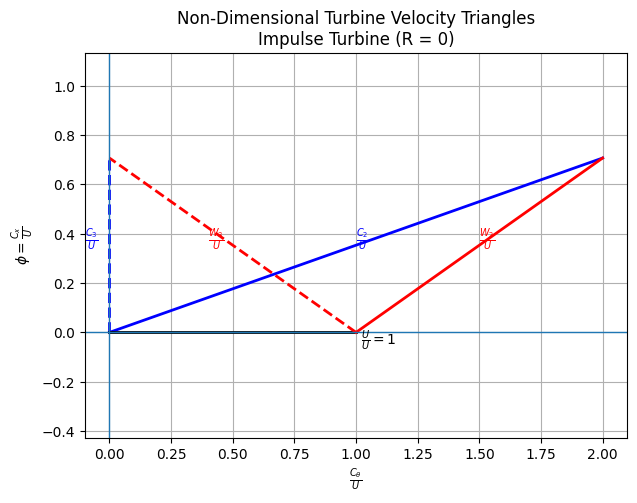

In [17]:
import matplotlib.pyplot as plt

# ==============================
# NON-DIMENSIONAL VELOCITIES
# ==============================

# Axial (constant)
phi = C_x / U

# Station 2 (Rotor Inlet / Stator Exit)
Ctheta2_bar = C_theta2 / U
Wu2_bar = Ctheta2_bar - 1.0

# Station 3 (Rotor Exit, axial discharge)
Ctheta3_bar = C_theta3 / U    # = 0 for axial exit
Wu3_bar = Ctheta3_bar - 1.0   # = -1

# ==============================
# PLOT COMBINED TRIANGLES
# ==============================

plt.figure(figsize=(7,5))

# ---- Absolute velocity triangles (blue) ----
# C2
plt.plot([0, Ctheta2_bar], [0, phi], 'b', linewidth=2)
# C3
plt.plot([0, Ctheta3_bar], [0, phi], 'b--', linewidth=2)

# ---- Blade speed line ----
plt.plot([0, 1], [0, 0], 'k', linewidth=2)

# ---- Relative velocity triangles (red) ----
# W2
plt.plot([1, Ctheta2_bar], [0, phi], 'r', linewidth=2)
# W3
plt.plot([1, Ctheta3_bar], [0, phi], 'r--', linewidth=2)

# ---- Labels ----
plt.text(Ctheta2_bar/2, phi/2, r"$\frac{C_2}{U}$", color='b')
plt.text(1.02, -0.05, r"$\frac{U}{U}=1$", color='k')
plt.text((1+Ctheta2_bar)/2, phi/2, r"$\frac{W_2}{U}$", color='r')

plt.text(Ctheta3_bar/2 - 0.1, phi/2, r"$\frac{C_3}{U}$", color='b')
plt.text((1+Ctheta3_bar)/2 - 0.1, phi/2, r"$\frac{W_3}{U}$", color='r')

# ---- Axes ----
plt.axhline(0, linewidth=1)
plt.axvline(0, linewidth=1)

plt.xlabel(r"$\frac{C_\theta}{U}$")
plt.ylabel(r"$\phi = \frac{C_x}{U}$")
plt.title("Non-Dimensional Turbine Velocity Triangles\nImpulse Turbine (R = 0)")

plt.grid(True)
plt.axis('equal')
plt.show()


### Whole Engine Design

In [34]:
import math
import numpy as np
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple

# ==============================================================================
# ENGINE CONSTANTS AND CONFIGURATION
# ==============================================================================

@dataclass
class EngineConstants:
    """Universal constants for the engine design"""
    # Gas properties
    R_AIR: float = 287.05          # J/kg·K
    R_GAS: float = 287.0           # J/kg·K (combustion products)
    GAMMA_AIR: float = 1.4         # Specific heat ratio (air)
    GAMMA_GAS: float = 1.33        # Specific heat ratio (combustion products)
    CP_AIR: float = 1005.0         # J/kg·K (air)
    CP_GAS: float = 1200.0         # J/kg·K (combustion products)
    
    # Fuel properties
    LHV_KEROSENE: float = 43.2e6   # J/kg
    AFR_STOICH: float = 14.7       # Stoichiometric air-fuel ratio
    
    # Standard conditions
    P0: float = 101325.0           # Pa (sea level)
    T0: float = 288.15             # K (sea level)
    
    # Material limits
    T_WALL_MAX: float = 1100.0     # K (max wall temperature)
    T_MAX_AD: float = 2200.0       # K (adiabatic flame temp limit)


# ==============================================================================
# ENGINE STATE CLASS
# ==============================================================================

class EngineState:
    """Stores thermodynamic state at each station"""
    def __init__(self, station: str):
        self.station = station
        self.T = 0.0        # Temperature [K]
        self.P = 0.0        # Pressure [Pa]
        self.rho = 0.0      # Density [kg/m³]
        self.h = 0.0        # Enthalpy [J/kg]
        self.s = 0.0        # Entropy [J/kg·K]
        self.V = 0.0        # Velocity [m/s]
        self.M = 0.0        # Mach number
        self.m_dot = 0.0    # Mass flow rate [kg/s]
    
    def update_from_T_P(self, T: float, P: float, gamma: float, R: float):
        """Update state from temperature and pressure"""
        self.T = T
        self.P = P
        self.rho = P / (R * T)
        self.h = gamma * R * T / (gamma - 1)
        
    def __str__(self):
        return (f"Station {self.station}: "
                f"T={self.T:.1f}K, P={self.P/1000:.1f}kPa, "
                f"rho={self.rho:.3f}kg/m³, V={self.V:.1f}m/s")


# ==============================================================================
# ENGINE COMPONENT CLASSES
# ==============================================================================

class Compressor:
    """Centrifugal Compressor Component"""
    
    def __init__(self, constants: EngineConstants):
        self.const = constants
        
        # Design parameters with defaults
        self.pi_c = 2.5          # Pressure ratio
        self.m_dot_air = 0.15    # kg/s
        self.eta_c = 0.85        # Isentropic efficiency
        self.psi = 0.55          # Loading coefficient
        self.beta_2 = 60.0       # Backward swept angle [deg]
        self.zeta = 0.2          # Hub/tip ratio
        self.delta = 0.6         # Rotor tip diameter ratio
        
        # Geometric constraints
        self.D2_max = 0.075      # Max impeller diameter [m]
        self.M_max = 0.9         # Max Mach number
        
        # Calculated parameters
        self.N_rpm = 0.0         # Rotational speed [RPM]
        self.U2 = 0.0            # Tip speed [m/s]
        self.D2 = 0.0            # Impeller diameter [m]
        self.wc = 0.0            # Compressor work [J/kg]
        
    def design(self, inlet_state: EngineState) -> EngineState:
        """Design the compressor given inlet conditions"""
        
        # 1. Isentropic and total enthalpy rise
        T02_T01_ideal = self.pi_c**((self.const.GAMMA_AIR - 1) / self.const.GAMMA_AIR)
        T02_T01 = 1 + (1 / self.eta_c) * (T02_T01_ideal - 1)
        T02 = inlet_state.T * T02_T01
        
        # 2. Compressor work
        self.wc = self.const.CP_AIR * (T02 - inlet_state.T)
                
        # 2. Impeller tip speed from loading (keep simple model)
        self.U2 = math.sqrt(max(self.wc, 1e-6) / max(self.psi, 1e-3))

        # Initial diameter from conservative tip-speed limit (e.g., 450 m/s)
        tip_limit = 450.0
        N_rps_guess = 1000.0 / 60.0  # 1000 RPM baseline to start geometry
        self.D2 = min(self.D2_max, max(0.03, self.U2 / (math.pi * N_rps_guess)))

        # Iteratively adjust D2 to satisfy tip-speed and Mach constraints
        for _ in range(30):
            N_rps = self.U2 / (math.pi * self.D2)
            self.N_rpm = N_rps * 60.0
            tip_speed = math.pi * self.D2 * N_rps  # = U2

            # 4. Impeller outlet velocity components
            beta2_rad = math.radians(self.beta_2)
            Cu2 = min(self.U2, self.wc / max(self.U2, 1e-6))  # bound Cu2 ≤ U2
            Cr2 = (self.U2 - Cu2) / max(math.tan(beta2_rad), 1e-3)
            C2 = math.sqrt(max(Cu2, 0.0)**2 + max(Cr2, 0.0)**2)

            # 6. Mach number check (static estimate at impeller exit)
            T02 = inlet_state.T * (1 + (1/self.eta_c) * (self.pi_c**((self.const.GAMMA_AIR-1)/self.const.GAMMA_AIR) - 1))
            T2_est = max(200.0, T02 - 0.5 * C2**2 / self.const.CP_AIR)
            a2 = math.sqrt(self.const.GAMMA_AIR * self.const.R_AIR * T2_est)
            M2 = C2 / max(a2, 1e-6)

            # Adjust geometry if constraints violated
            if tip_speed > tip_limit:
                self.D2 *= 1.05
                continue
            if M2 > self.M_max:
                # First, soften flow angles; then enlarge diameter slightly
                self.beta_2 = min(70.0, self.beta_2 + 3.0)
                self.D2 *= 1.03
                continue
            # If constraints satisfied, lock values and break
            break
        
        # 4. Impeller outlet velocity components
        Cu2 = self.wc / self.U2
        beta2_rad = math.radians(self.beta_2)
        Cr2 = (self.U2 - Cu2) / math.tan(beta2_rad)
        C2 = math.sqrt(Cu2**2 + Cr2**2)
        
        # 5. Inducer geometry
        Rt1 = self.delta * (self.D2 / 2)
        Rh1 = self.zeta * Rt1
        A1 = math.pi * (Rt1**2 - Rh1**2)
        
        # 6. Mach number check
        T2_est = T02 - 0.5 * C2**2 / self.const.CP_AIR
        a2 = math.sqrt(self.const.GAMMA_AIR * self.const.R_AIR * T2_est)
        M2 = C2 / a2
        
        if M2 > self.M_max:
            # Adjust geometry to reduce Mach number
            self.beta_2 = min(70.0, self.beta_2 + 5.0)
            return self.design(inlet_state)  # Recursive redesign
        
        # 7. Create outlet state
        outlet = EngineState("3")
        P03 = inlet_state.P * self.pi_c
        outlet.update_from_T_P(T02, P03, self.const.GAMMA_AIR, self.const.R_AIR)
        outlet.m_dot = self.m_dot_air
        
        # Store design parameters
        self.Cu2 = Cu2
        self.Cr2 = Cr2
        self.C2 = C2
        self.T02 = T02
        self.P03 = P03
        self.M2 = M2
        self.Rt1 = Rt1
        self.Rh1 = Rh1
        self.A1 = A1
        
        return outlet
    
    def get_design_summary(self) -> Dict:
        """Return compressor design summary"""
        return {
            "Pressure Ratio": self.pi_c,
            "Mass Flow Rate": self.m_dot_air,
            "Efficiency": self.eta_c,
            "Rotational Speed [RPM]": self.N_rpm,
            "Impeller Diameter [m]": self.D2,
            "Tip Speed [m/s]": self.U2,
            "Work [kJ/kg]": self.wc / 1000,
            "Exit Mach Number": self.M2,
            "Beta_2 [deg]": self.beta_2,
            "Loading Coefficient": self.psi,
            "Hub/Tip Ratio": self.zeta,
            "Tip Diameter Ratio": self.delta,
            "Inducer Outer Radius [m]": self.Rt1,
            "Inducer Hub Radius [m]": self.Rh1,
            "Inducer Area [m²]": self.A1
        }


class Combustor:
    """Combustion Chamber Component"""
    
    def __init__(self, constants: EngineConstants):
        self.const = constants
        
        # Design parameters
        self.T4_target = 1000.0    # Target outlet temperature [K]
        self.eta_comb = 0.97       # Combustion efficiency
        self.pi_b = 0.97           # Pressure loss factor
        self.pattern_factor_limit = 0.25
        self.L_over_D = 2.0
        
        # Calculated parameters
        self.m_dot_f = 0.0         # Fuel flow [kg/s]
        self.f = 0.0               # Fuel-air ratio
        self.phi = 0.0             # Equivalence ratio
        self.T4_actual = 0.0       # Actual outlet temperature [K]
        
        # Geometry
        self.D_ref = 0.0
        self.D_liner = 0.0
        self.L_total = 0.0
        self.theta = 0.0           # Loading parameter
        
    def design(self, inlet_state: EngineState, m_dot_air: float) -> EngineState:
        """Design combustor given compressor outlet conditions"""
        
        # 1. Calculate fuel flow with adiabatic limits
        T3 = inlet_state.T
        P3 = inlet_state.P
        
        # Estimate max possible T4
        cp_avg = (self.const.CP_AIR + self.const.CP_GAS) / 2
        f_st = 1.0 / self.const.AFR_STOICH
        T4_max = T3 + (self.eta_comb * f_st * self.const.LHV_KEROSENE) / \
                (cp_avg * (1 + f_st))
        
        # Clamp T4 to 95% of theoretical max
        self.T4_actual = min(self.T4_target, 0.95 * T4_max)
        
        # 2. Fuel flow calculation
        self.m_dot_f = (m_dot_air * self.const.CP_GAS * 
                       (self.T4_actual - T3)) / \
                       (self.eta_comb * self.const.LHV_KEROSENE)
        self.f = self.m_dot_f / m_dot_air
        self.phi = self.f / f_st
        
        # 3. Reference geometry (iterative for loading parameter)
        mfp_design = 0.003  # Mass flow parameter
        A_ref = (m_dot_air * math.sqrt(T3)) / (P3 * mfp_design) * 1.2
        
        # Loading parameter iteration
        for _ in range(20):
            self.D_ref = math.sqrt(4.0 * A_ref / math.pi)
            theta_const = (P3**1.75 * math.exp(T3/300.0)) / m_dot_air
            self.theta = theta_const * A_ref * (self.D_ref**0.75)
            
            if self.theta > 7.3e7:  # Theta max
                A_ref *= 1.05
            elif self.theta < 0.9 * 7.3e7:
                A_ref *= 0.98
            else:
                break
        
        # 4. Combustor geometry based on residence time
        A_liner = 0.70 * A_ref
        self.D_liner = math.sqrt(4.0 * A_liner / math.pi)
        
        # Residence time calculation
        T_avg = (T3 + self.T4_actual) / 2
        rho_avg = P3 / (self.const.R_GAS * T_avg)
        
        
        for _ in range(15):
            self.L_total = self.L_over_D * self.D_liner
            vol_comb = A_liner * self.L_total
            tau_res = (rho_avg * vol_comb) / m_dot_air
            
            if tau_res > 0.010:  # Max residence time
                self.L_over_D *= 0.95
            elif tau_res < 0.010 * 0.8:
                self.L_over_D *= 1.03
            else:
                break
        
        # 5. Create outlet state
        outlet = EngineState("4")
        P4 = P3 * self.pi_b
        outlet.update_from_T_P(self.T4_actual, P4, 
                              self.const.GAMMA_GAS, self.const.R_GAS)
        outlet.m_dot = m_dot_air + self.m_dot_f
        
        return outlet
    
    def get_design_summary(self) -> Dict:
        """Return combustor design summary"""
        return {
            "Outlet Temperature [K]": self.T4_actual,
            "Fuel Flow [kg/s]": self.m_dot_f,
            "Fuel-Air Ratio": self.f,
            "Equivalence Ratio": self.phi,
            "Pressure Loss Factor": self.pi_b,
            "Reference Diameter [m]": self.D_ref,
            "Liner Diameter [m]": self.D_liner,
            "Combustor Length [m]": self.L_total,
            "Loading Parameter": self.theta,
            "Efficiency": self.eta_comb,
            "L_over_D": self.L_over_D
        }


class Turbine:
    """Axial Turbine Component"""
    
    def __init__(self, constants: EngineConstants):
        self.const = constants
        
        # Design parameters
        self.R_turbine = 0.0      # Degree of reaction (0 for impulse)
        self.alpha3 = 0.0         # Exit flow angle [deg]
        self.e_t = 0.90           # Polytropic efficiency
        self.psi = 1.8            # Stage loading coefficient
        self.phi = 0.7            # Flow coefficient
        
        # Calculated parameters
        self.N_rpm = 0.0          # Rotational speed [RPM]
        self.U = 0.0              # Rotor velocity [m/s]
        self.r_m = 0.0            # Mean radius [m]
        self.w_t = 0.0            # Turbine work [J/kg]
        self.pi_t = 0.0           # Pressure ratio
        
        # Geometry
        self.h1 = 0.0             # Annulus height at inlet [m]
        self.h2 = 0.0             # Annulus height at rotor [m]
        self.h3 = 0.0             # Annulus height at outlet [m]
        
    def design(self, inlet_state: EngineState, 
               compressor_work: float, 
               compressor_N_rpm: float,
               m_dot_total: float) -> EngineState:
        """Design turbine to match compressor work"""
        
        # 1. Required turbine work (equals compressor work plus mechanical losses)
        self.w_t = compressor_work * 1.02  # 2% mechanical loss
        
        # 2. Use compressor rotational speed
        self.N_rpm = compressor_N_rpm
        Omega = 2 * math.pi * self.N_rpm / 60
        
        # 3. Stage loading coefficient for impulse turbine
        self.psi = 2 * (1 - self.R_turbine)
        self.U = math.sqrt(self.w_t / self.psi)
        
        # 4. Flow coefficient (optimum condition)
        self.phi = math.sqrt((self.psi/2)**2 - 0.5 - self.R_turbine*(self.R_turbine-1))
        
        # 5. Mean radius
        self.r_m = self.U / Omega
        
        # 6. Velocity triangles
        C_x = self.phi * self.U  # Axial velocity
        
        # Rotor inlet (station 2)
        C_theta2 = self.w_t / self.U  # For R=0 and axial exit
        C2 = math.sqrt(C_x**2 + C_theta2**2)
        alpha2 = math.degrees(math.atan2(C_theta2, C_x))
        
        # Rotor outlet (station 3)
        C3 = C_x  # Axial exit
        alpha3_rad = math.radians(self.alpha3)
        C_theta3 = C3 * math.sin(alpha3_rad)
        W_theta3 = self.U + C_theta3
        W3 = math.sqrt(C_x**2 + W_theta3**2)
        beta3 = math.degrees(math.atan2(W_theta3, C_x))
        
        # 7. Thermodynamic calculations
        T_t1 = inlet_state.T
        P_t1 = inlet_state.P
        
        # Total temperature at rotor exit
        T_t3 = T_t1 - self.w_t / self.const.CP_GAS
        
        # Total pressure ratio
        tau_t = T_t3 / T_t1
        self.pi_t = tau_t**(self.const.GAMMA_GAS / 
                           ((self.const.GAMMA_GAS - 1) * self.e_t))
        
        P_t3 = self.pi_t * P_t1
        
        # Static temperatures
        T2 = T_t1 - C2**2 / (2 * self.const.CP_GAS)
        T3 = T_t3 - C3**2 / (2 * self.const.CP_GAS)
        
        # 8. Geometric calculations
        P2 = P_t1 * (T2 / T_t1)**(self.const.GAMMA_GAS / 
                                   (self.const.GAMMA_GAS - 1))
        P3 = P_t3 * (T3 / T_t3)**(self.const.GAMMA_GAS / 
                                   (self.const.GAMMA_GAS - 1))
        
        rho2 = P2 / (self.const.R_GAS * T2)
        rho3 = P3 / (self.const.R_GAS * T3)
        
        A2 = m_dot_total / (rho2 * C_x)
        A3 = m_dot_total / (rho3 * C_x)
        
        self.h2 = A2 / (2 * math.pi * self.r_m)
        self.h3 = A3 / (2 * math.pi * self.r_m)
        
        # 9. Blade design (simplified)
        alpha2_rad = math.radians(alpha2)
        beta3_rad = math.radians(beta3)
        
        # Stator solidity (Zweifel criterion)
        sigma_NGV = 1.25 * math.sin(2 * alpha2_rad) / math.cos(math.radians(alpha2/2))
        
        # Rotor solidity
        sigma_rotor = 2.5 * math.sin(2 * beta3_rad) / math.cos(beta3_rad)
        
        # 10. Create outlet state
        outlet = EngineState("5")
        outlet.update_from_T_P(T_t3, P_t3, self.const.GAMMA_GAS, self.const.R_GAS)
        outlet.V = C3
        outlet.m_dot = m_dot_total
        
        # Store design parameters
        self.alpha2 = alpha2
        self.beta3 = beta3
        self.C2 = C2
        self.C3 = C3
        self.sigma_NGV = sigma_NGV
        self.sigma_rotor = sigma_rotor
        self.T_t3 = T_t3
        self.P_t3 = P_t3
        
        return outlet
    
    def get_design_summary(self) -> Dict:
        """Return turbine design summary"""
        return {
            "Rotational Speed [RPM]": self.N_rpm,
            "Stage Loading (ψ)": self.psi,
            "Flow Coefficient (φ)": self.phi,
            "Rotor Velocity [m/s]": self.U,
            "Mean Radius [m]": self.r_m,
            "Pressure Ratio": self.pi_t,
            "Work [kJ/kg]": self.w_t / 1000,
            "Efficiency": self.e_t,
            "Degree of Reaction": self.R_turbine,
            "Annulus Height [mm]": self.h2 * 1000,
            "Stator Solidity": self.sigma_NGV,
            "Rotor Solidity": self.sigma_rotor
        }


class Nozzle:
    """Converging Nozzle Component"""
    
    def __init__(self, constants: EngineConstants):
        self.const = constants
        
        # Design parameters
        self.eta_n = 0.98          # Nozzle efficiency
        self.Cd = 0.98             # Discharge coefficient
        
        # Calculated parameters
        self.A8 = 0.0              # Exit area [m²]
        self.V9 = 0.0              # Exit velocity [m/s]
        self.F = 0.0               # Thrust [N]
        self.SFC = 0.0             # Specific fuel consumption [kg/N·s]
        
    def design(self, inlet_state: EngineState, 
               P_ambient: float,
               m_dot_fuel: float) -> EngineState:
        """Design nozzle for maximum thrust"""
        
        # 1. Check for choked flow
        P8 = inlet_state.P
        T8 = inlet_state.T
        m_dot_total = inlet_state.m_dot
        
        P_critical = P8 * (2 / (self.const.GAMMA_GAS + 1)) ** \
                    (self.const.GAMMA_GAS / (self.const.GAMMA_GAS - 1))
        
        is_choked = P_ambient < P_critical
        
        if is_choked:
            # Choked flow
            P9 = P_critical
            T9 = T8 * (2 / (self.const.GAMMA_GAS + 1))
            M9 = 1.0
        else:
            # Unchoked flow
            P9 = P_ambient
            T9 = T8 * (P9 / P8) ** ((self.const.GAMMA_GAS - 1) / self.const.GAMMA_GAS)
            M9 = math.sqrt(2 / (self.const.GAMMA_GAS - 1) * 
                          ((P8 / P9) ** ((self.const.GAMMA_GAS - 1) / self.const.GAMMA_GAS) - 1))
        
        # 2. Exit velocity
        V9 = M9 * math.sqrt(self.const.GAMMA_GAS * self.const.R_GAS * T9)
        self.V9 = V9 * self.eta_n  # Apply efficiency
        
        # 3. Exit area
        rho9 = P9 / (self.const.R_GAS * T9)
        self.A8 = m_dot_total / (rho9 * self.V9 * self.Cd)
        
        # 4. Thrust calculation (static sea level)
        F_gross = m_dot_total * self.V9 + (P9 - P_ambient) * self.A8
        self.F = F_gross
        
        # 5. Specific fuel consumption
        if self.F > 0:
            self.SFC = m_dot_fuel / self.F
        else:
            self.SFC = float('inf')
        
        # Create exit state
        outlet = EngineState("9")
        outlet.update_from_T_P(T9, P9, self.const.GAMMA_GAS, self.const.R_GAS)
        outlet.V = self.V9
        outlet.M = M9
        outlet.m_dot = m_dot_total
        
        return outlet
    
    def get_design_summary(self) -> Dict:
        """Return nozzle design summary"""
        return {
            "Exit Area [cm²]": self.A8 * 10000,
            "Exit Velocity [m/s]": self.V9,
            "Thrust [N]": self.F,
            "Specific Thrust [N·s/kg]": self.F / (self.V9 * 0.01) if self.V9 > 0 else 0,
            "SFC [kg/N·s]": self.SFC,
            "Discharge Coefficient": self.Cd,
            "Nozzle Efficiency": self.eta_n
        }


# ==============================================================================
# MAIN ENGINE CLASS
# ==============================================================================

class MicrojetEngine:
    """Complete Microjet Engine Integration"""
    
    def __init__(self, 
                 m_dot_air: float = 0.15,
                 pi_c: float = 2.0,
                 T4_design: float = 1000.0,
                 zeta: float = 0.2,
                 delta: float = 0.6,
                 psi: float = 0.55,
                 beta_2: float = 60.0,
                 D2_MAX: float = 0.075,
                 L_over_D: float = 2.0):
        
        self.const = EngineConstants()
        
        # Store input parameters
        self.m_dot_air = m_dot_air
        self.pi_c = pi_c
        self.T4_design = T4_design
        self.zeta = zeta
        self.delta = delta
        self.psi = psi
        self.beta_2 = beta_2
        self.D2_MAX = D2_MAX
        self.L_over_D = L_over_D
        
        # Initialize components
        self.compressor = Compressor(self.const)
        self.combustor = Combustor(self.const)
        self.turbine = Turbine(self.const)
        self.nozzle = Nozzle(self.const)
        
        # Initialize stations
        self.stations = {
            "0": EngineState("0"),  # Ambient
            "1": EngineState("1"),  # Intake inlet
            "2": EngineState("2"),  # Compressor inlet
            "3": EngineState("3"),  # Compressor outlet / Combustor inlet
            "4": EngineState("4"),  # Combustor outlet / Turbine inlet
            "5": EngineState("5"),  # Turbine outlet / Nozzle inlet
            "9": EngineState("9")   # Nozzle outlet
        }
        
        # Performance metrics
        self.performance = {}
        
    def design_engine(self, 
                      M0: float = 0.0,
                      altitude: float = 0.0,
                      T_ambient: Optional[float] = None,
                      P_ambient: Optional[float] = None) -> None:
        """Complete engine design cycle"""
        
        #print("=" * 70)
        #print("MICROJET ENGINE - INTEGRATED DESIGN")
        #print("=" * 70)
        
        # 1. Set ambient conditions
        if T_ambient is None:
            T_ambient = self.const.T0
        if P_ambient is None:
            P_ambient = self.const.P0
        
        self.stations["0"].update_from_T_P(T_ambient, P_ambient,
                                          self.const.GAMMA_AIR, self.const.R_AIR)
        self.stations["0"].V = M0 * math.sqrt(self.const.GAMMA_AIR * 
                                             self.const.R_AIR * T_ambient)
        
        # 2. Intake (simple, no ram recovery at static condition)
        self.stations["1"].update_from_T_P(T_ambient, P_ambient,
                                          self.const.GAMMA_AIR, self.const.R_AIR)
        self.stations["1"].m_dot = self.m_dot_air
        
        # 3. Configure compressor with input parameters
        self.compressor.pi_c = self.pi_c
        self.compressor.m_dot_air = self.m_dot_air
        self.compressor.zeta = self.zeta
        self.compressor.delta = self.delta
        self.compressor.psi = self.psi
        self.compressor.beta_2 = self.beta_2
        self.compressor.D2_max = self.D2_MAX
        
        # 4. Design compressor
        # print("\n[1] DESIGNING COMPRESSOR...")
        self.stations["3"] = self.compressor.design(self.stations["1"])
        
        # 5. Configure and design combustor
        # print("\n[2] DESIGNING COMBUSTOR...")
        self.combustor.T4_target = self.T4_design
        self.combustor.L_over_D = self.L_over_D
        self.stations["4"] = self.combustor.design(self.stations["3"], self.m_dot_air)
        
        # 6. Configure and design turbine
        # print("\n[3] DESIGNING TURBINE...")
        # Get compressor work and RPM to size turbine
        compressor_work = self.compressor.wc
        compressor_N_rpm = self.compressor.N_rpm
        m_dot_total = self.m_dot_air + self.combustor.m_dot_f
        
        # Set turbine to match compressor
        self.turbine.N_rpm = compressor_N_rpm
        self.stations["5"] = self.turbine.design(
            self.stations["4"], 
            compressor_work,
            compressor_N_rpm,
            m_dot_total
        )
        
        # 7. Design nozzle
        # print("\n[4] DESIGNING NOZZLE...")
        self.stations["9"] = self.nozzle.design(
            self.stations["5"],
            P_ambient,
            self.combustor.m_dot_f
        )
        
        # 8. Calculate overall performance
        self._calculate_performance(P_ambient)
        
        # print("\n" + "=" * 70)
        # print("ENGINE DESIGN COMPLETE")
        # print("=" * 70)
    
    def _calculate_performance(self, P_ambient: float) -> None:
        """Calculate overall engine performance metrics"""
        
        # Thermal efficiency
        delta_ke= 0.5 * self.m_dot_air * (self.stations["9"].V**2 - self.stations["0"].V**2)
        Q_in = self.combustor.m_dot_f * self.const.LHV_KEROSENE
        
        if Q_in > 0:
            self.performance["thermal_efficiency"] = delta_ke / Q_in * 100
        else:
            self.performance["thermal_efficiency"] = 0
        
        # Propulsive efficiency
        V0 = self.stations["0"].V
        V9 = self.stations["9"].V
        
        if V9 > V0:
            self.performance["propulsive_efficiency"] = \
                2 * V0 / (V0 + V9) * 100
        else:
            self.performance["propulsive_efficiency"] = 0 
        
        # Overall efficiency
        self.performance["overall_efficiency"] = \
            (self.performance["thermal_efficiency"] / 100) * \
            (self.performance["propulsive_efficiency"] / 100) * 100
        
        # Thrust specific fuel consumption (TSFC)
        if self.nozzle.F > 0:
            self.performance["TSFC"] = self.combustor.m_dot_f / self.nozzle.F
        else:
            self.performance["TSFC"] = float('inf')
        
        # Pressure ratios
        self.performance["OPR"] = self.stations["3"].P / self.stations["1"].P
        self.performance["TPR"] = self.stations["4"].P / self.stations["5"].P
        
        # Temperatures
        self.performance["T3_T1"] = self.stations["3"].T / self.stations["1"].T
        self.performance["T4_T3"] = self.stations["4"].T / self.stations["3"].T
        
    def print_design_summary(self) -> None:
        """Print comprehensive design summary"""
        
        print("\n" + "=" * 70)
        print("ENGINE DESIGN SUMMARY")
        print("=" * 70)
        
        print("\nINPUT PARAMETERS:")
        print(f"  Mass Flow Rate (air): {self.m_dot_air:.3f} kg/s")
        print(f"  Compressor Pressure Ratio: {self.pi_c:.2f}")
        print(f"  Target Turbine Inlet Temp: {self.T4_design:.0f} K")
        print(f"  Hub/Tip Ratio (ζ): {self.zeta:.2f}")
        print(f"  Rotor Tip Ratio (δ): {self.delta:.2f}")
        
        print("\n" + "-" * 70)
        print("THERMODYNAMIC CYCLE:")
        print("-" * 70)
        
        print("\nStation States:")
        for station in ["0", "1", "3", "4", "5", "9"]:
            state = self.stations[station]
            print(f"  {state}")
        
        print("\n" + "-" * 70)
        print("COMPONENT DESIGNS:")
        print("-" * 70)
        
        # Compressor summary
        comp_data = self.compressor.get_design_summary()
        print("\nCOMPRESSOR (Centrifugal):")
        for key, value in comp_data.items():
            print(f"  {key:<25}: {value}")
        
        # Combustor summary
        comb_data = self.combustor.get_design_summary()
        print("\nCOMBUSTOR:")
        for key, value in comb_data.items():
            print(f"  {key:<25}: {value}")
        
        # Turbine summary
        turb_data = self.turbine.get_design_summary()
        print("\nTURBINE (Axial):")
        for key, value in turb_data.items():
            print(f"  {key:<25}: {value}")
        
        # Nozzle summary
        noz_data = self.nozzle.get_design_summary()
        print("\nNOZZLE (Converging):")
        for key, value in noz_data.items():
            print(f"  {key:<25}: {value}")
        
        print("\n" + "-" * 70)
        print("OVERALL PERFORMANCE:")
        print("-" * 70)
        
        print(f"\nThrust Performance:")
        print(f"  Gross Thrust: {self.nozzle.F:.2f} N")
        print(f"  Specific Thrust: {self.nozzle.F/self.m_dot_air:.2f} N·s/kg")
        print(f"  Exit Velocity: {self.stations['9'].V:.1f} m/s")
        
        print(f"\nEfficiencies:")
        print(f"  Thermal Efficiency: {self.performance['thermal_efficiency']:.2f}%")
        print(f"  Propulsive Efficiency: {self.performance['propulsive_efficiency']:.2f}%")
        print(f"  Overall Efficiency: {self.performance['overall_efficiency']:.2f}%")
        
        print(f"\nFuel Consumption:")
        print(f"  Fuel Flow Rate: {self.combustor.m_dot_f*1000:.2f} g/s")
        print(f"  TSFC: {self.performance['TSFC']*1e6:.2f} mg/N·s")
        
        print(f"\nOperational Parameters:")
        print(f"  Overall Pressure Ratio (OPR): {self.performance['OPR']:.2f}")
        print(f"  Turbine Pressure Ratio (TPR): {self.performance['TPR']:.2f}")
        print(f"  T3/T1 Ratio: {self.performance['T3_T1']:.2f}")
        print(f"  T4/T3 Ratio: {self.performance['T4_T3']:.2f}")
        
        print("\n" + "=" * 70)
    
    def export_ts_diagram_data(self) -> Dict[str, List]:
        """Export data for T-s diagram plotting"""
        
        data = {
            "station": [],
            "T": [],
            "P": [],
            "s": []
        }
        
        # Calculate entropy relative to station 0
        s_ref = 0
        for station in ["0", "1", "3", "4", "5", "9"]:
            state = self.stations[station]
            
            # Simplified entropy calculation
            if station in ["0", "1", "3"]:
                gamma = self.const.GAMMA_AIR
                R = self.const.R_AIR
                Cp = self.const.CP_AIR
            else:
                gamma = self.const.GAMMA_GAS
                R = self.const.R_GAS
                Cp = self.const.CP_GAS
            
            s = Cp * math.log(state.T) - R * math.log(state.P)
            if station == "0":
                s_ref = s
            
            data["station"].append(station)
            data["T"].append(state.T)
            data["P"].append(state.P)
            data["s"].append(s - s_ref)  # Relative entropy
        
        return data


# ==============================================================================
# EXAMPLE USAGE
# ==============================================================================

if __name__ == "__main__":
    
    
    engine = MicrojetEngine(
        m_dot_air=0.148847,      # kg/s
        pi_c=2.500000,            # Pressure ratio
        T4_design=1100.000000,    # K
        zeta=0.326336,            # Hub/tip ratio
        delta=0.718045,            # Rotor tip ratio
        psi= 0.579021,            # Loading coefficient
        beta_2= 44.593343,         # Backward swept angle [deg]
        D2_MAX=0.083856,         # Max impeller diameter [m]
        L_over_D=1.991060             # Combustor length-to-diameter ratio
    )
    
    engine.design_engine(M0=0.0)  # Static sea level
    engine.print_design_summary()

    
    
    
    # Get data for plotting
    ts_data = engine.export_ts_diagram_data()
    print("\nT-s Diagram Data Available for Stations:", ts_data["station"])


ENGINE DESIGN SUMMARY

INPUT PARAMETERS:
  Mass Flow Rate (air): 0.149 kg/s
  Compressor Pressure Ratio: 2.50
  Target Turbine Inlet Temp: 1100 K
  Hub/Tip Ratio (ζ): 0.33
  Rotor Tip Ratio (δ): 0.72

----------------------------------------------------------------------
THERMODYNAMIC CYCLE:
----------------------------------------------------------------------

Station States:
  Station 0: T=288.1K, P=101.3kPa, rho=1.225kg/m³, V=0.0m/s
  Station 1: T=288.1K, P=101.3kPa, rho=1.225kg/m³, V=0.0m/s
  Station 3: T=389.6K, P=253.3kPa, rho=2.265kg/m³, V=0.0m/s
  Station 4: T=1100.0K, P=245.7kPa, rho=0.778kg/m³, V=0.0m/s
  Station 5: T=1013.3K, P=170.2kPa, rho=0.585kg/m³, V=161.2m/s
  Station 9: T=891.0K, P=101.3kPa, rho=0.396kg/m³, V=521.3m/s

----------------------------------------------------------------------
COMPONENT DESIGNS:
----------------------------------------------------------------------

COMPRESSOR (Centrifugal):
  Pressure Ratio           : 2.5
  Mass Flow Rate           : 0

#### Engine Optimization

In [19]:
import numpy as np
from scipy.optimize import differential_evolution

class EngineOptimizer:
    def __init__(self, engine_class):
        self.engine_class = engine_class

    def objective_function(self, params):
        m_dot_air, pi_c, T4_design, zeta, delta, psi, beta_2, D2_MAX, L_over_D  = params

        engine = self.engine_class(
            m_dot_air=m_dot_air,
            pi_c=pi_c,
            T4_design=T4_design,
            zeta=zeta,
            delta=delta,
            psi=psi,
            beta_2=beta_2,
            D2_MAX=D2_MAX,
            L_over_D=L_over_D
        )

        try:
            engine.design_engine(M0=0.0)
            perf = engine.performance
            F = engine.nozzle.F
            TSFC = perf.get("TSFC", np.inf)
            thermal_eff = perf.get("thermal_efficiency", 0.0)

            if not np.isfinite(F) or not np.isfinite(TSFC) or F <= 0:
                return 1e10

            F_norm = F / max(m_dot_air, 1e-6)
            TSFC_norm = TSFC * 1e6
            thermal_eff_pct = thermal_eff

            score = ( + 1.0 * F_norm
                      - 0.5 * TSFC_norm
                      + 0.5 * thermal_eff_pct )

            penalty = 0.0
            T4 = engine.stations["4"].T
            if T4 > engine.const.T_MAX_AD or T4 <= engine.stations["3"].T:
                penalty += 5e3

            M2 = getattr(engine.compressor, "M2", 0.0)
            if M2 > engine.compressor.M_max:
                penalty += 5e3

            pi_t = getattr(engine.turbine, "pi_t", 1.0)
            if pi_t >= 1.0:
                penalty += 5e3

            D2 = engine.compressor.D2
            N_rpm = engine.compressor.N_rpm
            if D2 > engine.compressor.D2_max or D2 < 0.03:
                penalty += 3e3
            if N_rpm <= 0 or N_rpm > 100_000:
                penalty += 3e3

            return -(score - penalty)

        except Exception:
            return 1e10

    def optimize_scipy(self, initial_guess, bounds):
        result = differential_evolution(
            self.objective_function,
            bounds=bounds,
            maxiter=2000000,
            popsize=1000,
            tol=1e-5,
            mutation=(0.5, 1.0),
            recombination=0.7,
            polish=True,
            updating='deferred',
            workers=1,
            seed=42
        )
        return result.x, -result.fun


In [ ]:
optimizer = EngineOptimizer(MicrojetEngine)
bounds = [
    (0.1, 0.3), #mass Flow rate
    (1.5, 2.5), #PI_c
    (900.0, 1100.0),#T4
    (0.3, 0.6),#zeta
    (0.5, 0.7),#delta
    (0.4, 0.6), #psi
    (0.0, 60.0), #beta_2
    (0.055, 0.07), #D2_max
    (1.0, 2) #L_over_D
]
initial = [0.15, 2.0, 1000.0, 0.2, 0.6, 0.55, 40.0, 0.065, 2.0]
best_params, best_perf = optimizer.optimize_scipy(initial, bounds)


In [21]:

print("\n=== Optimization Results ===") 
for name, value in zip( 
                       ["m_dot_air", "pi_c", "T4_design", 
                        "zeta", "delta", "psi", "beta_2", 
                        "D2_MAX","L_over_D"], best_params ): 
    print(f"{name:12s}: {value:.6f}") 
print(f"\nBest performance score: {best_perf:.6f}")


=== Optimization Results ===
m_dot_air   : 0.206107
pi_c        : 2.500000
T4_design   : 1099.999995
zeta        : 0.408864
delta       : 0.654992
psi         : 0.564150
beta_2      : 48.173989
D2_MAX      : 0.083054
L_over_D    : 1.092913

Best performance score: 520.469593


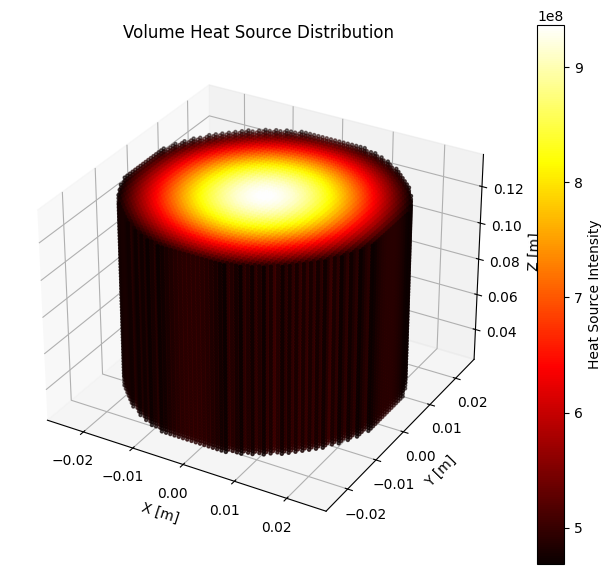

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# --------------------------------
# Parameters
# --------------------------------
Factor = 1.0

R_max = 0.02475
z_min, z_max = 0.03, 0.13
sigma = 0.0297

Q0 = 6.76e8 * Factor * 1.386

# --------------------------------
# Computational grid
# --------------------------------
nx, ny, nz = 60, 60, 60

x = np.linspace(-R_max, R_max, nx)
y = np.linspace(-R_max, R_max, ny)
z = np.linspace(z_min, z_max, nz)

X, Y, Z = np.meshgrid(x, y, z, indexing="ij")

R = np.sqrt(X**2 + Y**2)

# --------------------------------
# Volume heat source
# --------------------------------
Q = Q0 * np.exp(-(R / sigma)**2)

mask = (
    (R <= R_max) &
    (Z >= z_min) &
    (Z <= z_max)
)

Q[~mask] = 0.0

# --------------------------------
# Visualization (3D scatter)
# --------------------------------
threshold = 0.05 * Q.max()
idx = Q > threshold

fig = plt.figure(figsize=(8, 7))
ax = fig.add_subplot(111, projection="3d")

p = ax.scatter(
    X[idx], Y[idx], Z[idx],
    c=Q[idx],
    s=5,
    cmap="hot"
)

ax.set_xlabel("X [m]")
ax.set_ylabel("Y [m]")
ax.set_zlabel("Z [m]")
ax.set_title("Volume Heat Source Distribution")

fig.colorbar(p, ax=ax, label="Heat Source Intensity")
plt.show()


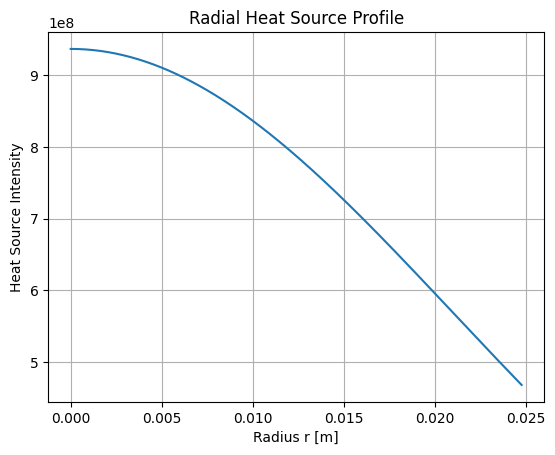

In [23]:
r = np.linspace(0, R_max, 300)
Q_r = Q0 * np.exp(-(r / sigma)**2)

plt.figure()
plt.plot(r, Q_r)
plt.xlabel("Radius r [m]")
plt.ylabel("Heat Source Intensity")
plt.title("Radial Heat Source Profile")
plt.grid(True)
plt.show()


In [24]:
import numpy as np
from scipy.integrate import tplquad

# ==============================
# User-defined parameters
# ==============================
Q0 = 6.76e8          # Base power density factor
Factor = 1.0
target_power_kw = 129.6  # Desired total power in kW

# Cylinder geometry
R = 0.02475  # m, radius
z_min = 0.02
z_max = 0.12

# Gaussian parameters (adjustable)
z0 = 0.05     # Flame peak
sigma_r = 0.0297  # Radial spread
sigma_z = 0.03    # Axial spread

# ==============================
# Power density function with mask
# ==============================
def power_density(z, y, x, C):
    r2 = x**2 + y**2
    # Apply circular and axial mask
    if r2 <= R**2 and z_min <= z <= z_max:
        return Q0 * Factor * C * np.exp(-(np.sqrt(r2)/sigma_r)**2) * np.exp(-((z - z0)/sigma_z)**2)
    else:
        return 0.0

# ==============================
# Numerical integration over cylinder
# ==============================
def compute_total_power(C):
    result, _ = tplquad(
        lambda z, y, x: power_density(z, y, x, C),
        -R, R,  # x limits
        lambda x: -np.sqrt(R**2 - x**2),
        lambda x: np.sqrt(R**2 - x**2),  # y limits
        lambda x, y: z_min,
        lambda x, y: z_max
    )
    return result

# ==============================
# Solve for C to achieve target power
# ==============================
total_power_for_C1 = compute_total_power(C=1.0)
C_needed = target_power_kw * 1e3 / total_power_for_C1  # Convert kW to W

print(f"Computed C for target power {target_power_kw} kW: {C_needed:.4f}")



Computed C for target power 129.6 kW: 2.8221


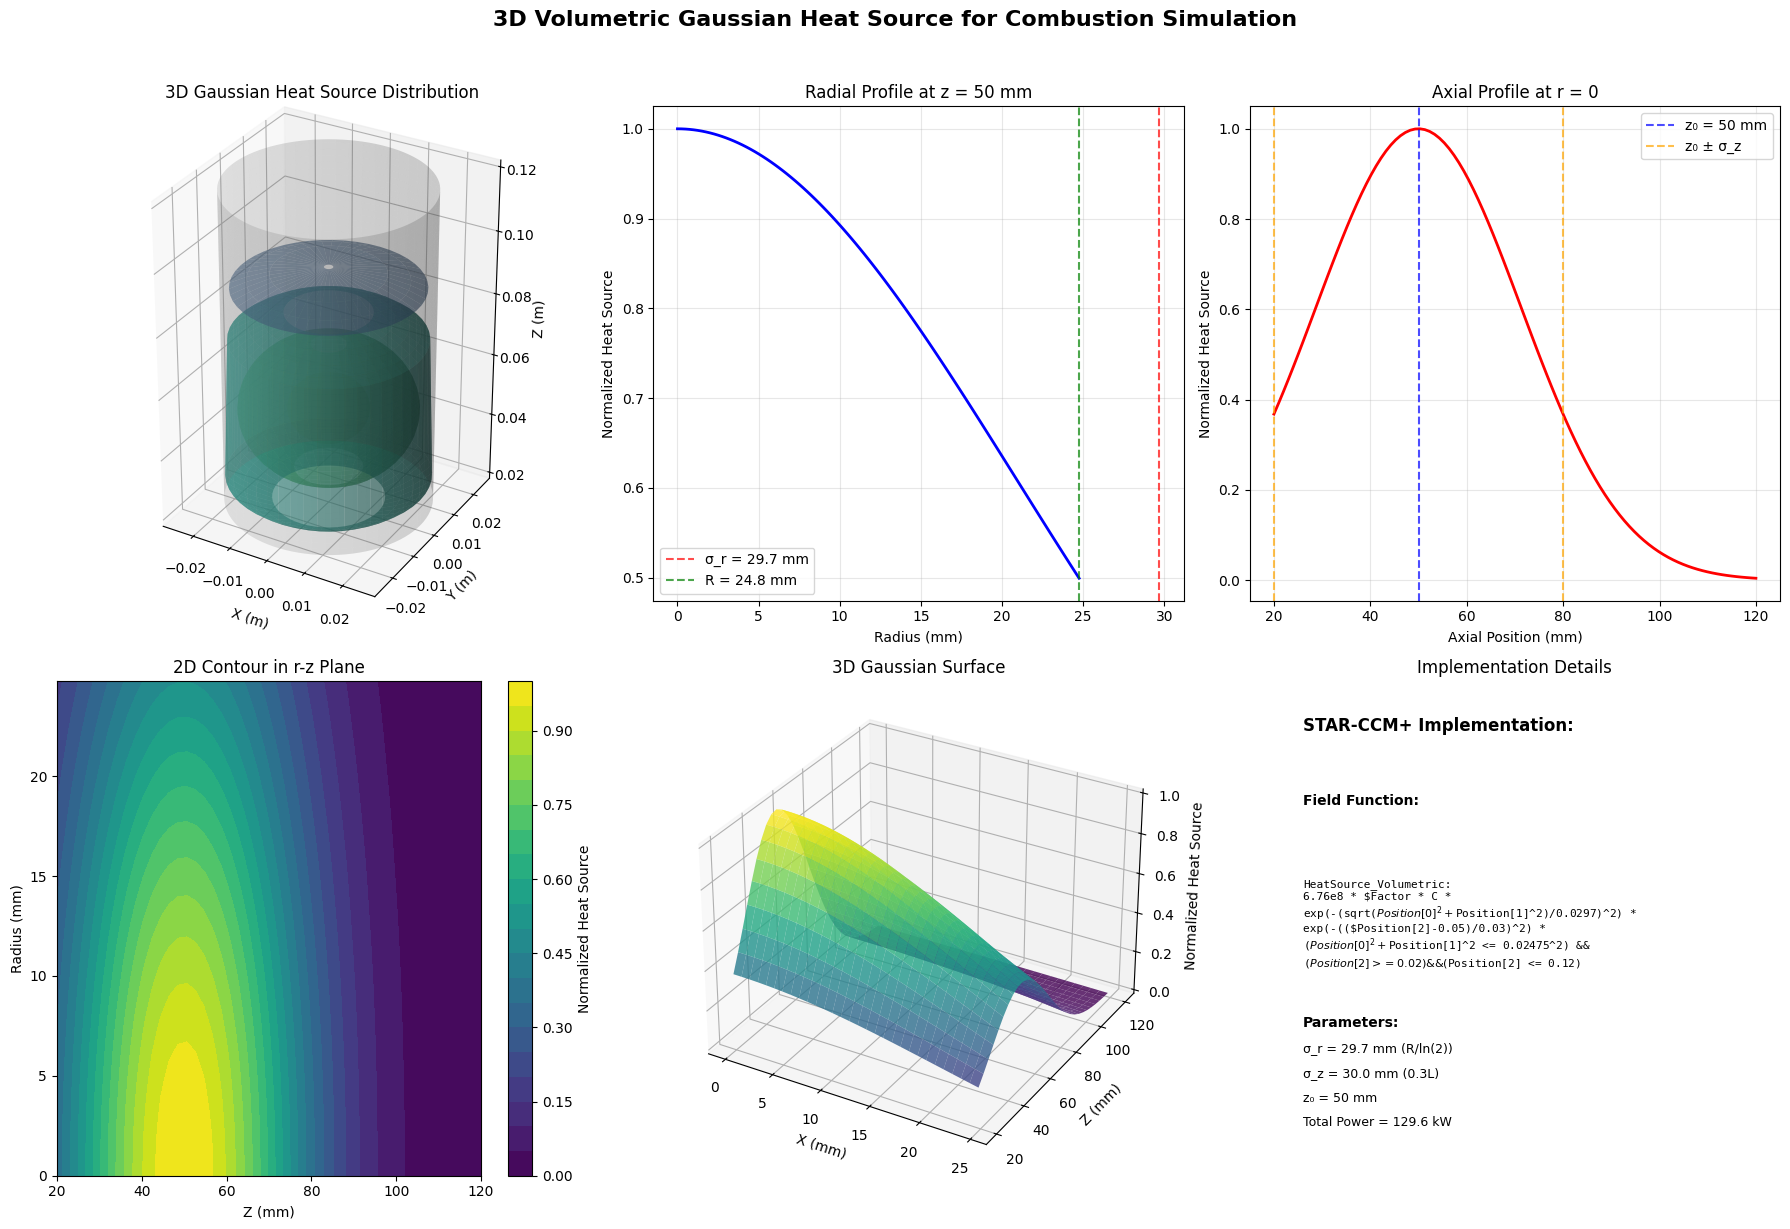

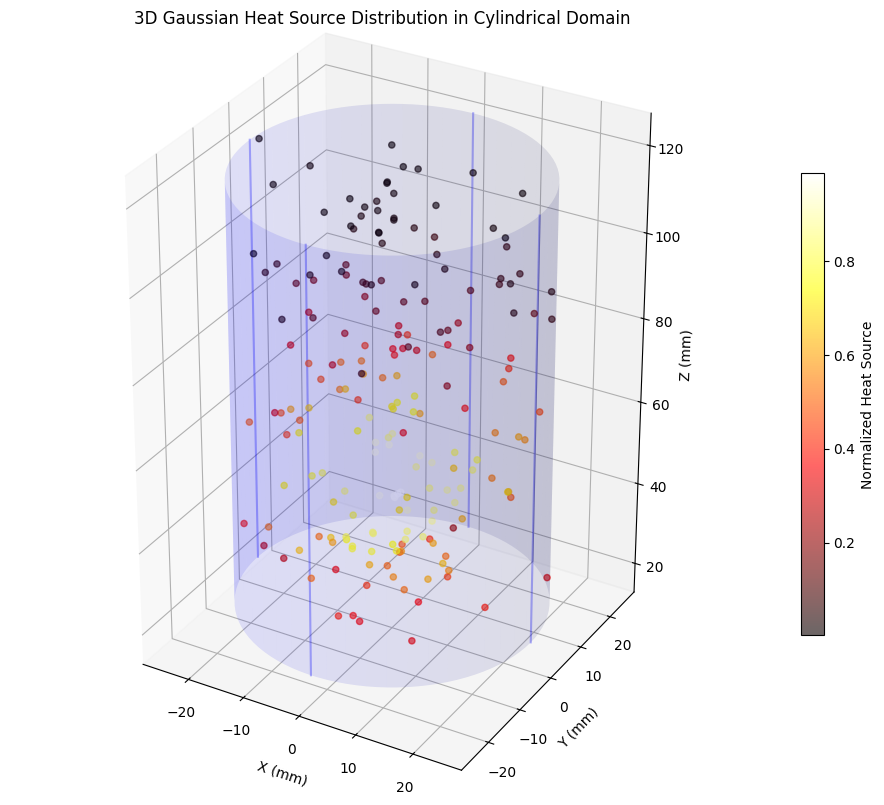

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

# Parameters from the description
z0 = 0.05  # m - flame peak position
sigma_r = 0.0297  # m - radial standard deviation (R/ln(2) ≈ 0.0297 for R=0.02475)
sigma_z = 0.03  # m - axial standard deviation (0.3L with L=0.1m)
R_cylinder = 0.02475  # m - cylinder radius
z_min, z_max = 0.02, 0.12  # m - axial bounds

# Create grid
r = np.linspace(0, R_cylinder, 50)
z = np.linspace(z_min, z_max, 50)
R, Z = np.meshgrid(r, z)

# Calculate normalized heat source (without C factor for visualization)
# Radial Gaussian: exp(-(r/sigma_r)^2)
# Axial Gaussian: exp(-((z-z0)/sigma_z)^2)
Q = np.exp(-(R/sigma_r)**2) * np.exp(-((Z - z0)/sigma_z)**2)

# Apply cylindrical boundaries
Q[R > R_cylinder] = 0
Q[Z < z_min] = 0
Q[Z > z_max] = 0

# Convert to Cartesian coordinates for 3D plot
theta = np.linspace(0, 2*np.pi, 50)
Theta, R_3d = np.meshgrid(theta, r)
X = R_3d * np.cos(Theta)
Y = R_3d * np.sin(Theta)

# Create Z grid for 3D
Z_3d = np.tile(z.reshape(-1, 1), (1, 50))

# Calculate Q for 3D
Q_3d = np.zeros((len(z), len(theta), len(r)))
for i in range(len(z)):
    for j in range(len(theta)):
        Q_3d[i, j, :] = np.exp(-(r/sigma_r)**2) * np.exp(-((z[i]-z0)/sigma_z)**2)

# Apply boundaries
Q_3d_flat = Q_3d.reshape(-1)
Q_3d_flat[np.tile(r, len(z)*len(theta)) > R_cylinder] = 0
Q_3d = Q_3d_flat.reshape(Q_3d.shape)

# Create figure with subplots
fig = plt.figure(figsize=(18, 12))

# Plot 1: 3D Surface Plot
ax1 = fig.add_subplot(231, projection='3d')
# Create surface for outer boundary
theta_boundary = np.linspace(0, 2*np.pi, 100)
z_boundary = np.linspace(z_min, z_max, 100)
Theta_b, Z_b = np.meshgrid(theta_boundary, z_boundary)
X_b = R_cylinder * np.cos(Theta_b)
Y_b = R_cylinder * np.sin(Theta_b)

# Plot transparent cylinder
ax1.plot_surface(X_b, Y_b, Z_b, alpha=0.2, color='gray', edgecolor='none')

# Plot heat source isosurface (simplified representation)
levels = [0.1, 0.3, 0.6, 0.9]
colors = cm.viridis(np.linspace(0.3, 1, len(levels)))

for level, color in zip(levels, colors):
    # Create isosurface points
    theta_iso = np.linspace(0, 2*np.pi, 50)
    r_iso = sigma_r * np.sqrt(-np.log(level))  # Solve exp(-(r/sigma_r)^2) = level
    r_iso = np.minimum(r_iso, R_cylinder)
    
    # For each z, calculate corresponding radius
    z_vals = np.linspace(z_min, z_max, 50)
    r_vals = []
    z_vals_valid = []
    for z_val in z_vals:
        # Solve Q = level for this z
        z_part = np.exp(-((z_val - z0)/sigma_z)**2)
        if z_part <= level:
            continue
        r_val = sigma_r * np.sqrt(-np.log(level/z_part))
        if r_val <= R_cylinder:
            r_vals.append(r_val)
            z_vals_valid.append(z_val)
    
    if len(r_vals) > 0:
        # Create surface
        theta_grid, z_grid = np.meshgrid(theta_iso, z_vals_valid)
        r_grid = np.tile(r_vals, (len(theta_iso), 1)).T
        
        X_iso = r_grid * np.cos(theta_grid)
        Y_iso = r_grid * np.sin(theta_grid)
        
        ax1.plot_surface(X_iso, Y_iso, z_grid, alpha=0.6, 
                        color=color, edgecolor='none', linewidth=0.5)

ax1.set_xlabel('X (m)')
ax1.set_ylabel('Y (m)')
ax1.set_zlabel('Z (m)')
ax1.set_title('3D Gaussian Heat Source Distribution')
ax1.set_box_aspect([1, 1, 1.5])

# Plot 2: Radial Profile at z=z0
ax2 = fig.add_subplot(232)
r_profile = np.linspace(0, R_cylinder, 100)
Q_radial = np.exp(-(r_profile/sigma_r)**2)
ax2.plot(r_profile * 1000, Q_radial, 'b-', linewidth=2)
ax2.axvline(x=sigma_r * 1000, color='r', linestyle='--', alpha=0.7, 
           label=f'σ_r = {sigma_r*1000:.1f} mm')
ax2.axvline(x=R_cylinder * 1000, color='g', linestyle='--', alpha=0.7,
           label=f'R = {R_cylinder*1000:.1f} mm')
ax2.set_xlabel('Radius (mm)')
ax2.set_ylabel('Normalized Heat Source')
ax2.set_title(f'Radial Profile at z = {z0*1000:.0f} mm')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Axial Profile at r=0
ax3 = fig.add_subplot(233)
z_profile = np.linspace(z_min, z_max, 100)
Q_axial = np.exp(-((z_profile - z0)/sigma_z)**2)
ax3.plot(z_profile * 1000, Q_axial, 'r-', linewidth=2)
ax3.axvline(x=z0 * 1000, color='b', linestyle='--', alpha=0.7,
           label=f'z₀ = {z0*1000:.0f} mm')
ax3.axvline(x=(z0 + sigma_z) * 1000, color='orange', linestyle='--', alpha=0.7,
           label=f'z₀ ± σ_z')
ax3.axvline(x=(z0 - sigma_z) * 1000, color='orange', linestyle='--', alpha=0.7)
ax3.set_xlabel('Axial Position (mm)')
ax3.set_ylabel('Normalized Heat Source')
ax3.set_title('Axial Profile at r = 0')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: 2D Contour (r-z plane)
ax4 = fig.add_subplot(234)
contour = ax4.contourf(Z * 1000, R * 1000, Q, levels=20, cmap='viridis')
ax4.set_xlabel('Z (mm)')
ax4.set_ylabel('Radius (mm)')
ax4.set_title('2D Contour in r-z Plane')
plt.colorbar(contour, ax=ax4, label='Normalized Heat Source')

# Plot 5: Isometric view of Gaussian distribution
ax5 = fig.add_subplot(235, projection='3d')
# Create a mesh for the Gaussian surface
r_plot = np.linspace(0, R_cylinder, 30)
z_plot = np.linspace(z_min, z_max, 30)
R_plot, Z_plot = np.meshgrid(r_plot, z_plot)
Q_plot = np.exp(-(R_plot/sigma_r)**2) * np.exp(-((Z_plot - z0)/sigma_z)**2)

# Convert to Cartesian for surface plot
X_plot = R_plot * np.cos(0)  # At theta=0 for cross-section
Y_plot = R_plot * np.sin(0)
surf = ax5.plot_surface(X_plot * 1000, Z_plot * 1000, Q_plot, 
                       cmap='viridis', alpha=0.8, edgecolor='none')
ax5.set_xlabel('X (mm)')
ax5.set_ylabel('Z (mm)')
ax5.set_zlabel('Normalized Heat Source')
ax5.set_title('3D Gaussian Surface')

# Plot 6: Implementation illustration
ax6 = fig.add_subplot(236)
ax6.text(0.1, 0.9, 'STAR-CCM+ Implementation:', fontsize=12, fontweight='bold')
ax6.text(0.1, 0.75, 'Field Function:', fontsize=10, fontweight='bold')
implementation_text = """HeatSource_Volumetric:
6.76e8 * $Factor * C *
exp(-(sqrt($Position[0]^2 + $Position[1]^2)/0.0297)^2) *
exp(-(($Position[2]-0.05)/0.03)^2) *
($Position[0]^2 + $Position[1]^2 <= 0.02475^2) &&
($Position[2] >= 0.02) && ($Position[2] <= 0.12)"""
ax6.text(0.1, 0.6, implementation_text, fontsize=8, family='monospace',
        verticalalignment='top')
ax6.text(0.1, 0.3, 'Parameters:', fontsize=10, fontweight='bold')
ax6.text(0.1, 0.25, f'σ_r = {sigma_r*1000:.1f} mm (R/ln(2))', fontsize=9)
ax6.text(0.1, 0.2, f'σ_z = {sigma_z*1000:.1f} mm (0.3L)', fontsize=9)
ax6.text(0.1, 0.15, f'z₀ = {z0*1000:.0f} mm', fontsize=9)
ax6.text(0.1, 0.1, f'Total Power = 129.6 kW', fontsize=9)
ax6.set_xlim(0, 1)
ax6.set_ylim(0, 1)
ax6.set_xticks([])
ax6.set_yticks([])
ax6.set_title('Implementation Details')
ax6.spines['top'].set_visible(False)
ax6.spines['right'].set_visible(False)
ax6.spines['bottom'].set_visible(False)
ax6.spines['left'].set_visible(False)

plt.suptitle('3D Volumetric Gaussian Heat Source for Combustion Simulation', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Additional: Single comprehensive 3D plot
fig2 = plt.figure(figsize=(12, 10))
ax = fig2.add_subplot(111, projection='3d')

# Create more detailed 3D representation
# Generate points for the Gaussian distribution
n_points = 200
r_points = np.random.uniform(0, R_cylinder, n_points)
theta_points = np.random.uniform(0, 2*np.pi, n_points)
z_points = np.random.uniform(z_min, z_max, n_points)

# Calculate heat source values
Q_points = np.exp(-(r_points/sigma_r)**2) * np.exp(-((z_points - z0)/sigma_z)**2)

# Convert to Cartesian
x_points = r_points * np.cos(theta_points)
y_points = r_points * np.sin(theta_points)

# Scatter plot with color representing heat source
scatter = ax.scatter(x_points * 1000, y_points * 1000, z_points * 1000, 
                    c=Q_points, cmap='hot', s=20, alpha=0.6)

# Draw cylinder outline
theta_cyl = np.linspace(0, 2*np.pi, 100)
z_cyl = np.array([z_min, z_max])
Theta_cyl, Z_cyl = np.meshgrid(theta_cyl, z_cyl)
X_cyl = R_cylinder * np.cos(Theta_cyl) * 1000
Y_cyl = R_cylinder * np.sin(Theta_cyl) * 1000
ax.plot_surface(X_cyl, Y_cyl, Z_cyl * 1000, alpha=0.1, color='blue')

# Draw side of cylinder
z_side = np.linspace(z_min, z_max, 10)
theta_side = np.array([0, np.pi/2, np.pi, 3*np.pi/2])
for t in theta_side:
    x_side = R_cylinder * np.cos(t) * 1000
    y_side = R_cylinder * np.sin(t) * 1000
    ax.plot([x_side, x_side], [y_side, y_side], 
            [z_min*1000, z_max*1000], 'b-', alpha=0.3)

ax.set_xlabel('X (mm)')
ax.set_ylabel('Y (mm)')
ax.set_zlabel('Z (mm)')
ax.set_title('3D Gaussian Heat Source Distribution in Cylindrical Domain')
plt.colorbar(scatter, ax=ax, label='Normalized Heat Source', shrink=0.6)
ax.set_box_aspect([1, 1, 1.5])

plt.show()